In [1]:
DEBUG = True
break_counter = 0

# 1.Acquire HUST dataset from source

In [2]:
!wget https://data.mendeley.com/public-files/datasets/nsc7hnsg4s/files/5ca0ac3e-d598-4d07-8dcb-879aa047e98b/file_downloaded

--2026-01-27 10:28:40--  https://data.mendeley.com/public-files/datasets/nsc7hnsg4s/files/5ca0ac3e-d598-4d07-8dcb-879aa047e98b/file_downloaded
Resolving data.mendeley.com (data.mendeley.com)... 162.159.130.86, 162.159.133.86
Connecting to data.mendeley.com (data.mendeley.com)|162.159.130.86|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com/c1819429-ce74-415b-bca5-ae57536f11ee [following]
--2026-01-27 10:28:41--  https://prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com/c1819429-ce74-415b-bca5-ae57536f11ee
Resolving prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com)... 3.5.67.242, 3.5.67.217, 52.92.34.178, ...
Connecting to prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com)|3.5.67.242|:443... co

# 2.Process and extract current, voltage, time and cycles

In [3]:
!unzip file_downloaded

Archive:  file_downloaded
   creating: our_data/
  inflating: our_data/1-1.pkl        
  inflating: our_data/1-2.pkl        
  inflating: our_data/1-3.pkl        
  inflating: our_data/1-4.pkl        
  inflating: our_data/1-5.pkl        
  inflating: our_data/1-6.pkl        
  inflating: our_data/1-7.pkl        
  inflating: our_data/1-8.pkl        
  inflating: our_data/2-2.pkl        
  inflating: our_data/2-3.pkl        
  inflating: our_data/2-4.pkl        
  inflating: our_data/2-5.pkl        
  inflating: our_data/2-6.pkl        
  inflating: our_data/2-7.pkl        
  inflating: our_data/2-8.pkl        
  inflating: our_data/3-1.pkl        
  inflating: our_data/3-2.pkl        
  inflating: our_data/3-3.pkl        
  inflating: our_data/3-4.pkl        
  inflating: our_data/3-5.pkl        
  inflating: our_data/3-6.pkl        
  inflating: our_data/3-7.pkl        
  inflating: our_data/3-8.pkl        
  inflating: our_data/4-1.pkl        
  inflating: our_data/4-2.pkl        
 

In [4]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import random
from tqdm import tqdm
import numpy as np

base_path = 'our_data'
len(os.listdir(base_path)) #should be 77 cells

77

In [5]:
filenames_without_pkl = [file.rstrip('.pkl') for file in os.listdir(base_path)]
print(filenames_without_pkl)

['2-2', '9-8', '3-6', '8-2', '3-7', '3-4', '9-1', '1-8', '3-1', '7-7', '4-3', '6-1', '10-4', '3-8', '3-3', '1-1', '1-2', '4-7', '6-4', '7-6', '2-8', '6-5', '1-3', '1-4', '2-5', '6-3', '4-1', '8-7', '10-5', '9-7', '5-4', '1-7', '6-8', '7-2', '3-5', '8-4', '5-6', '7-8', '10-1', '2-3', '7-4', '3-2', '7-3', '2-7', '9-5', '10-7', '10-6', '5-2', '7-5', '10-3', '4-2', '5-7', '4-4', '1-6', '9-4', '6-2', '7-1', '5-5', '4-6', '9-6', '8-8', '2-4', '5-1', '10-2', '8-1', '2-6', '1-5', '6-6', '9-3', '9-2', '8-5', '5-3', '8-3', '4-5', '10-8', '8-6', '4-8']


# 3 a.Calculate SoC, SoH, extract RUL for 80% of 1.1Ah

In [6]:
#Current Integration Equation
import scipy.integrate as integrate
def current_integration(initial_SOC,C_rated,I_bat,t_start,t_end):
    change_in_charge,_ = integrate.quad(lambda t:float(I_bat),float(t_start),float(t_end)) 
    #print("Change in Charge : ",change_in_charge)
    return float(initial_SOC) + 100.0/float(C_rated) * change_in_charge

2-2


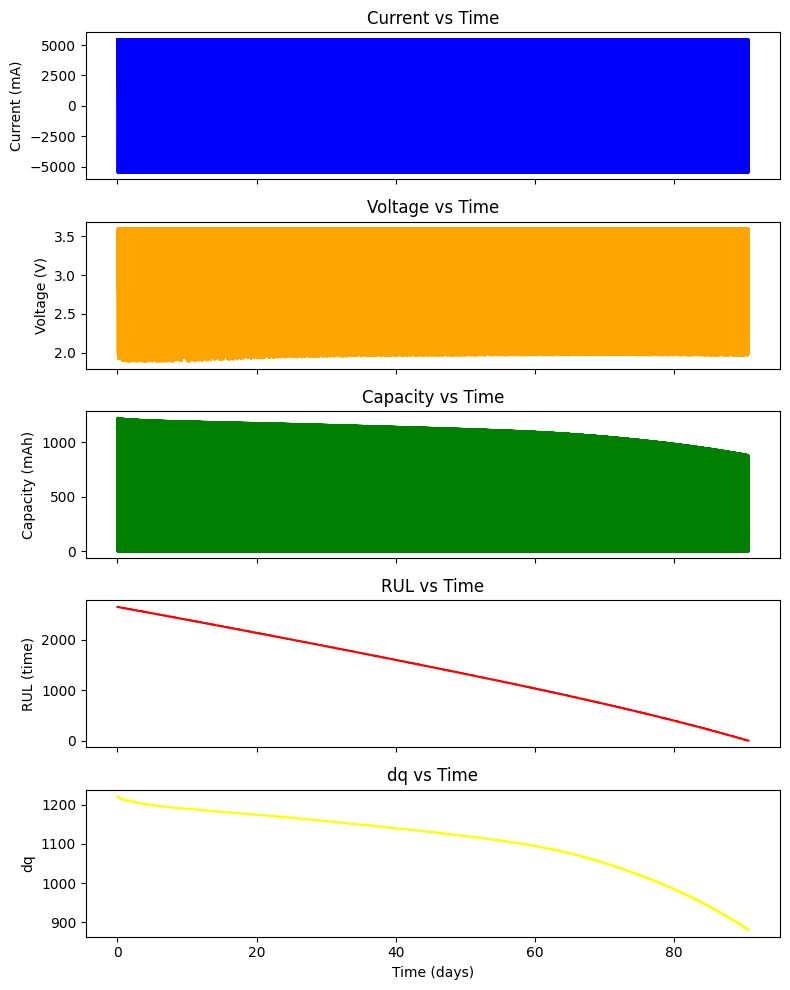

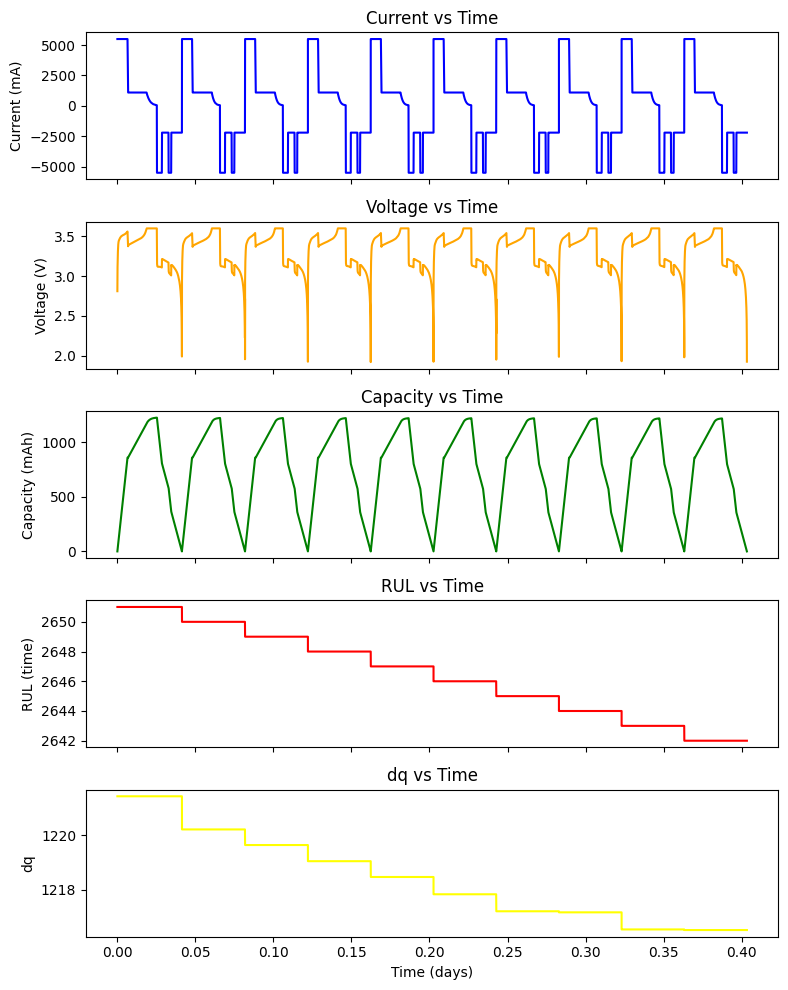

100%|██████████| 2651/2651 [01:42<00:00, 25.98it/s]


9-8


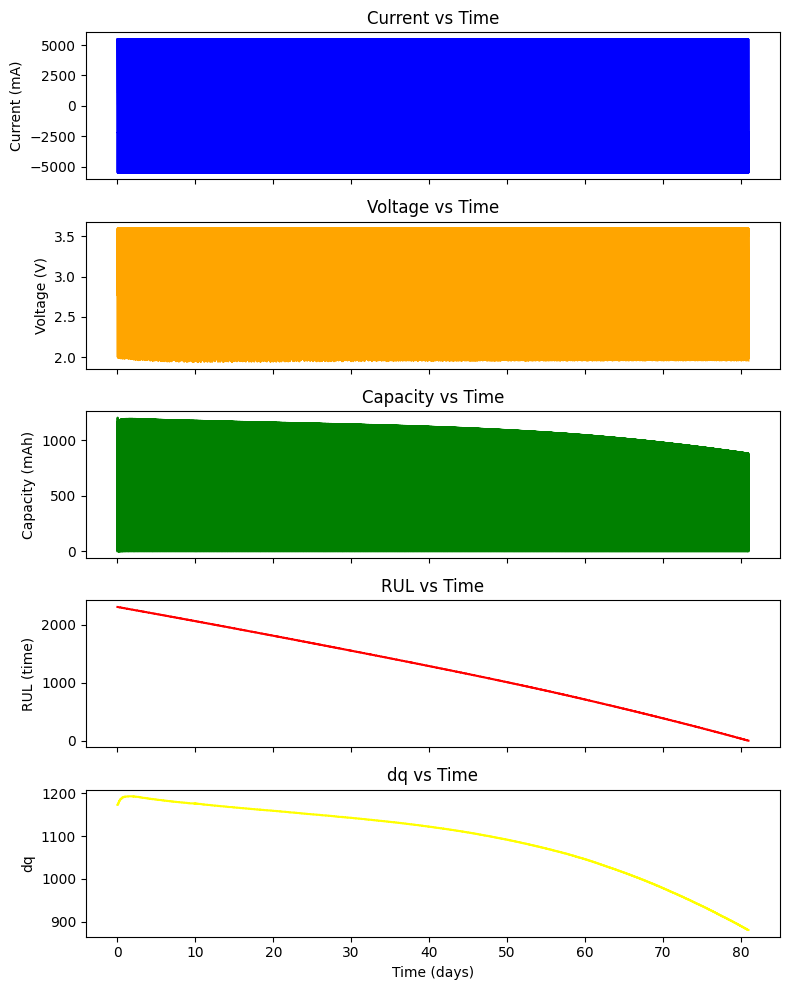

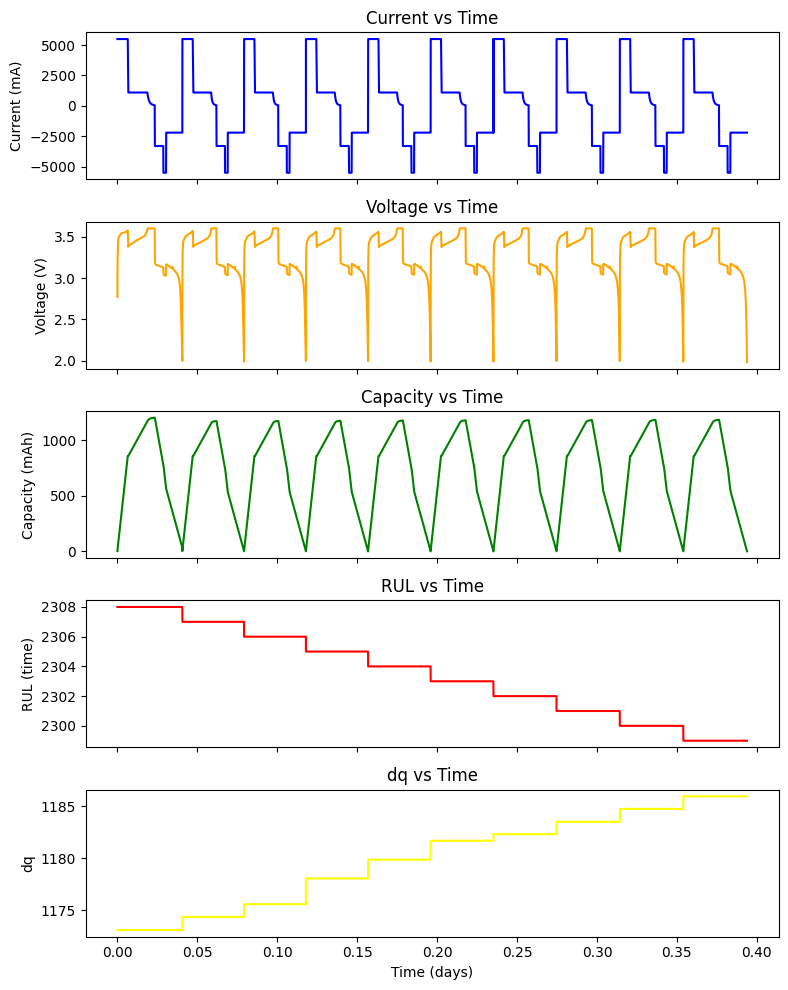

100%|██████████| 2308/2308 [01:22<00:00, 28.12it/s]


3-6


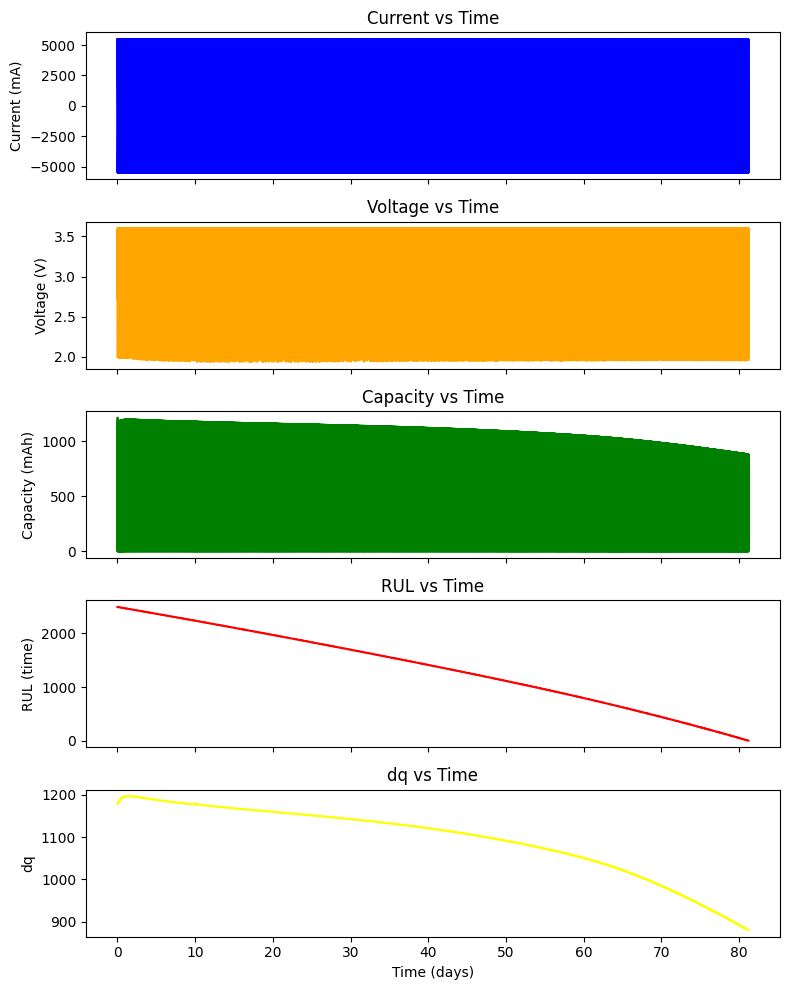

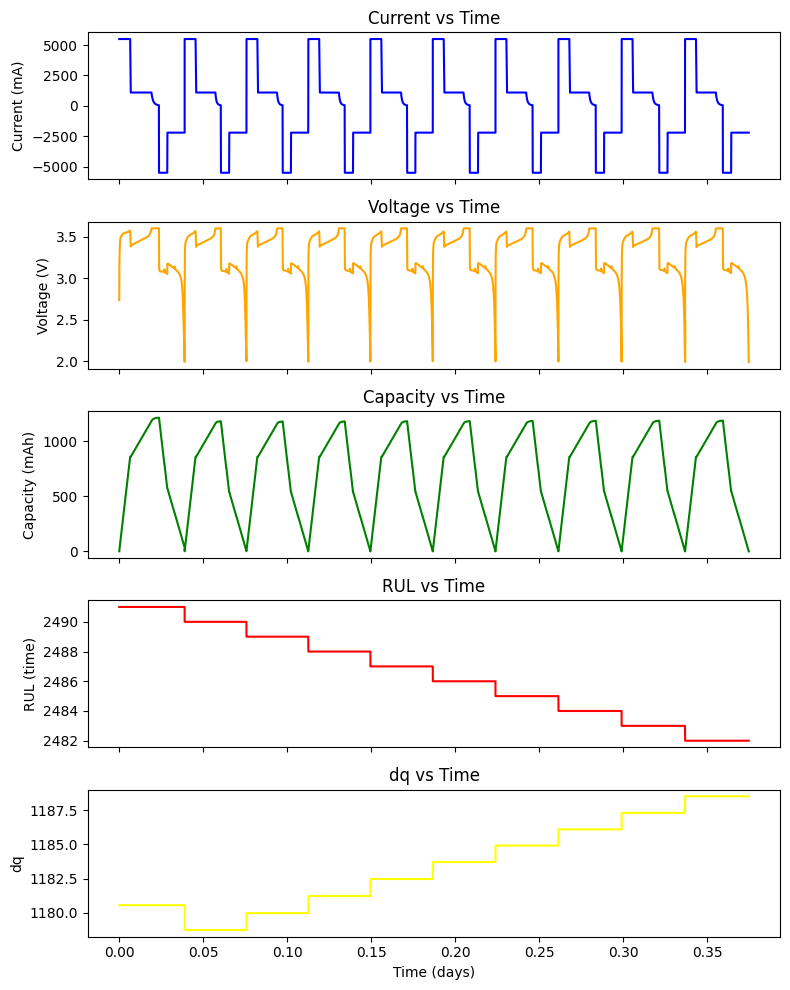

100%|██████████| 2491/2491 [01:23<00:00, 29.76it/s]


8-2


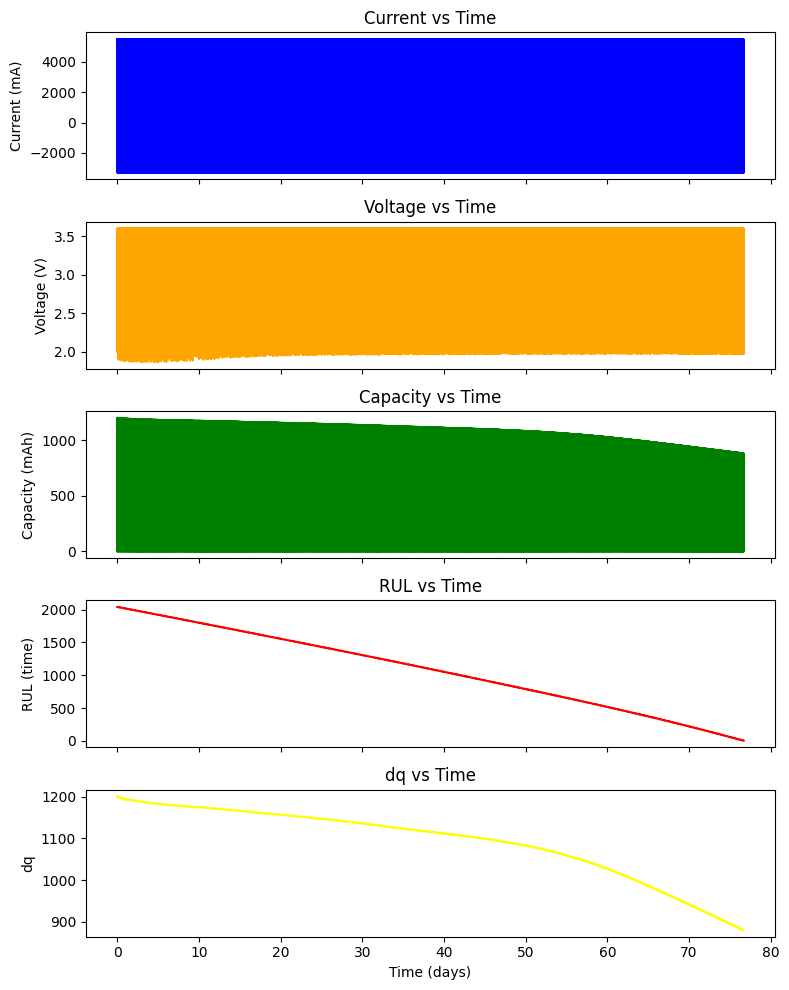

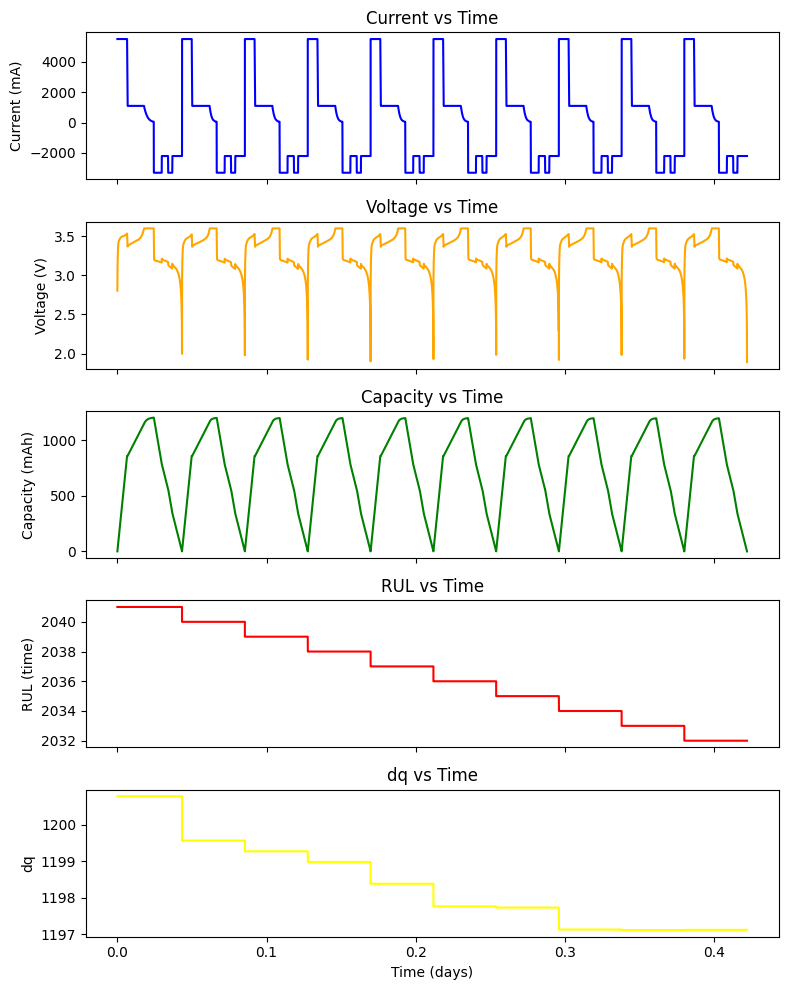

100%|██████████| 2041/2041 [01:25<00:00, 23.74it/s]


In [7]:
# Precompute constant
C_rated = 1100.0 * 3600

os.makedirs('plots/',exist_ok=True)
os.makedirs('csvs/',exist_ok=True)

for cycle_regimen in filenames_without_pkl:
    #cycle_regimen = random.choice(filenames_without_pkl)#'10-1'
    unpickled_df = pd.read_pickle(f'{base_path}/{cycle_regimen}.pkl')#,engine='pyarrow',dtype_backend='pyarrow')
    print(cycle_regimen)
    df = pd.DataFrame(unpickled_df[cycle_regimen])#,engine='pyarrow',dtype_backend='pyarrow')
    rul = unpickled_df[cycle_regimen]['rul']
    dq = unpickled_df[cycle_regimen]['dq']
    data = unpickled_df[cycle_regimen]['data']
    ### Faster Code ########

    # Prepare a list to store all DataFrames, so we only concatenate at the end
    df_list = []

    # Initialize the previous_last_time for cumulative time calculation
    previous_last_time = 0

    # Iterate over the data dictionary
    for cycle_number, cycle_data in data.items():
        df_data = pd.DataFrame(cycle_data)

        # Calculate cumulative time
        df_data['Time (s) cumu'] = df_data['Time (s)'] + previous_last_time

        # Add 'rul' and 'dq' columns directly without creating lists
        df_data['rul'] = rul[cycle_number]
        df_data['dq'] = dq[cycle_number]

        # Update the previous_last_time for the next cycle
        previous_last_time = df_data['Time (s) cumu'].iloc[-1]

        # Store the DataFrame in the list
        df_list.append(df_data)

    # Concatenate all DataFrames at once
    merge_df = pd.concat(df_list, ignore_index=True)

    # Sort only once if needed
    merge_df = merge_df.sort_values(by='Time (s) cumu', ascending=True).reset_index(drop=True)


    df = merge_df

    # Create a figure with 5 vertical subplots
    fig, axs = plt.subplots(5, 1, figsize=(8, 10), sharex=True)

    # Plot Current vs Time
    axs[0].plot(df['Time (s) cumu']/86400, df['Current (mA)'], color='blue')
    axs[0].set_ylabel('Current (mA)')
    axs[0].set_title('Current vs Time')

    # Plot Voltage vs Time
    axs[1].plot(df['Time (s) cumu']/86400, df['Voltage (V)'], color='orange')
    axs[1].set_ylabel('Voltage (V)')
    axs[1].set_title('Voltage vs Time')

    # Plot Capacity vs Time
    axs[2].plot(df['Time (s) cumu']/86400, df['Capacity (mAh)'], color='green')
    axs[2].set_ylabel('Capacity (mAh)')
    axs[2].set_title('Capacity vs Time')
    #axs[2].set_xlabel('Time (s)')

    # Plot RUL vs Time
    axs[3].plot(df['Time (s) cumu']/86400, df['rul'], color='red')
    axs[3].set_ylabel('RUL (time)')
    axs[3].set_title('RUL vs Time')
    #axs[3].set_xlabel('Time (s)')

    # Plot Capacity vs Time
    axs[4].plot(df['Time (s) cumu']/86400, df['dq'], color='yellow')
    axs[4].set_ylabel('dq')
    axs[4].set_title('dq vs Time')
    axs[4].set_xlabel('Time (days)')

    # Add some spacing between plots
    plt.tight_layout()

    # You can also specify the DPI (dots per inch) for better resolution
    plt.savefig('plots/'+cycle_regimen+'-full-plot.png', dpi=300)
    # Display the plots
    plt.show()


    df = merge_df#.copy()
    df = df[df['Cycle number']<11]

    # Create a figure with 5 vertical subplots
    fig, axs = plt.subplots(5, 1, figsize=(8, 10), sharex=True)

    # Plot Current vs Time
    axs[0].plot(df['Time (s) cumu']/86400, df['Current (mA)'], color='blue')
    axs[0].set_ylabel('Current (mA)')
    axs[0].set_title('Current vs Time')

    # Plot Voltage vs Time
    axs[1].plot(df['Time (s) cumu']/86400, df['Voltage (V)'], color='orange')
    axs[1].set_ylabel('Voltage (V)')
    axs[1].set_title('Voltage vs Time')

    # Plot Capacity vs Time
    axs[2].plot(df['Time (s) cumu']/86400, df['Capacity (mAh)'], color='green')
    axs[2].set_ylabel('Capacity (mAh)')
    axs[2].set_title('Capacity vs Time')
    #axs[2].set_xlabel('Time (s)')

    # Plot RUL vs Time
    axs[3].plot(df['Time (s) cumu']/86400, df['rul'], color='red')
    axs[3].set_ylabel('RUL (time)')
    axs[3].set_title('RUL vs Time')
    #axs[3].set_xlabel('Time (s)')

    # Plot Capacity vs Time
    axs[4].plot(df['Time (s) cumu']/86400, df['dq'], color='yellow')
    axs[4].set_ylabel('dq')
    axs[4].set_title('dq vs Time')
    axs[4].set_xlabel('Time (days)')

    # You can also specify the DPI (dots per inch) for better resolution
    plt.savefig('plots/'+cycle_regimen+'-first-10-plot.png', dpi=300)
    # Add some spacing between plots
    plt.tight_layout()

    # Display the plots
    plt.show()

    merge_df.loc[merge_df['Capacity (mAh)'] == 0, 'previous_SOC'] = 0
    
    # Temporary storage for the computed SOC values
    cc_soc_values = np.zeros(len(merge_df))
    
    # Process each group
    for _, group in tqdm(merge_df.groupby('Cycle number')):
        # Initialize variables
        soc_values = []
        initial_SOC = 0  # Assuming this starts at 0 for each group
    
        # Iterate over each row in the group
        t_end = group.iloc[0]['Time (s)']  # Set initial t_end to the first time value
    
        for i, row in group.iterrows():
            if row["previous_SOC"] == 0:
                # Reset SOC calculation at the start of a new cycle
                initial_SOC = row["previous_SOC"]
                I_bat = row['Current (mA)']
                t_start = row['Time (s)']
                t_end = t_start  # Initialize t_end for the first row
            else:
                # Use previous SOC and time values for the next row
                t_start = t_end
                t_end = row['Time (s)']
                I_bat = row['Current (mA)']
    
            # Calculate SOC
            SOC = current_integration(initial_SOC=initial_SOC, C_rated=C_rated, I_bat=I_bat, t_start=t_start, t_end=t_end)
    
            # Update the initial_SOC for the next iteration
            initial_SOC = SOC
    
            # Store the result
            soc_values.append(SOC)
    
        # Assign computed SOC values back to the original DataFrame using loc with index slicing
        cc_soc_values[group.index] = soc_values
    
    # Finally, assign all computed SOC values to the DataFrame column in a single operation
    merge_df["CC_SOC"] = cc_soc_values
    merge_df.to_csv('csvs/'+cycle_regimen+'.csv',index=False)
    if DEBUG:
        break_counter += 1
        if break_counter > 3:
            break_counter = 0
            break

100%|██████████| 2491/2491 [00:01<00:00, 1768.94it/s]


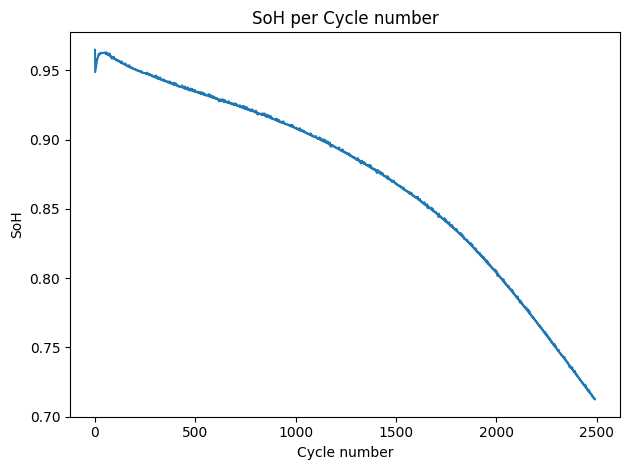

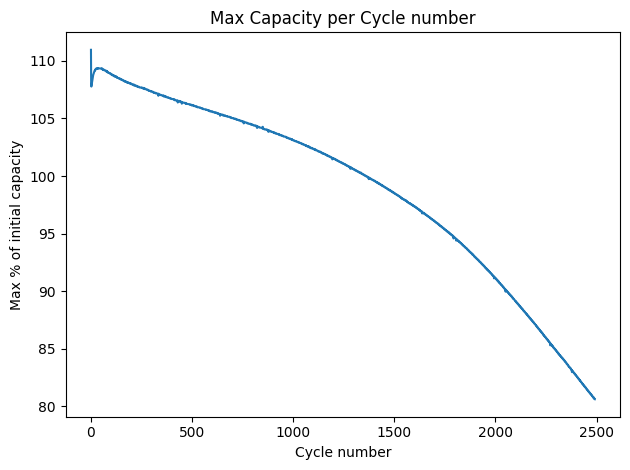

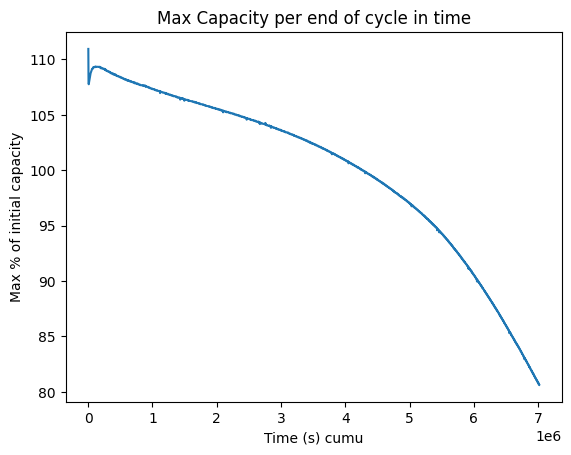

<Figure size 640x480 with 0 Axes>

100%|██████████| 2308/2308 [00:01<00:00, 1667.74it/s]


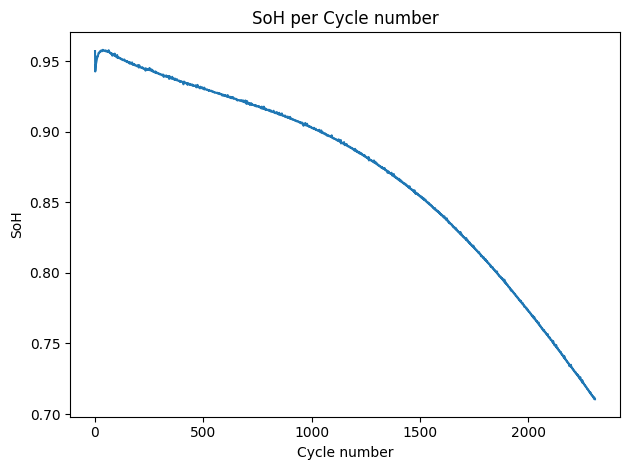

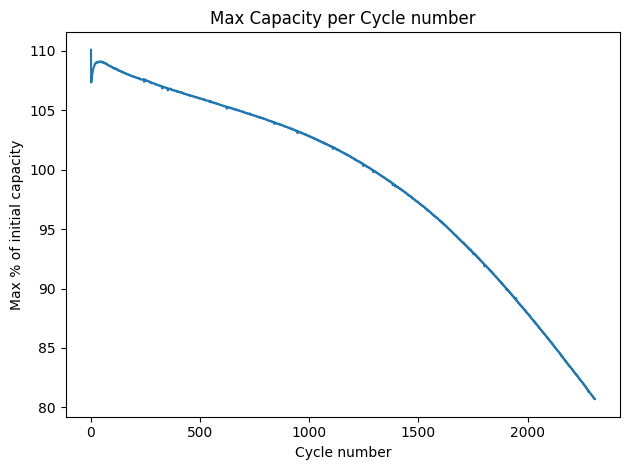

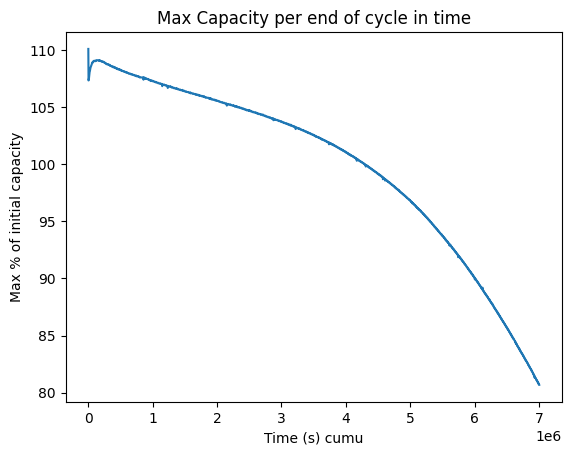

<Figure size 640x480 with 0 Axes>

100%|██████████| 2041/2041 [00:01<00:00, 1820.21it/s]


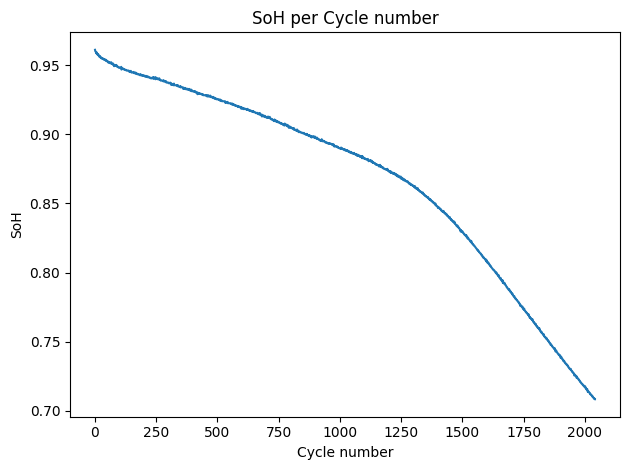

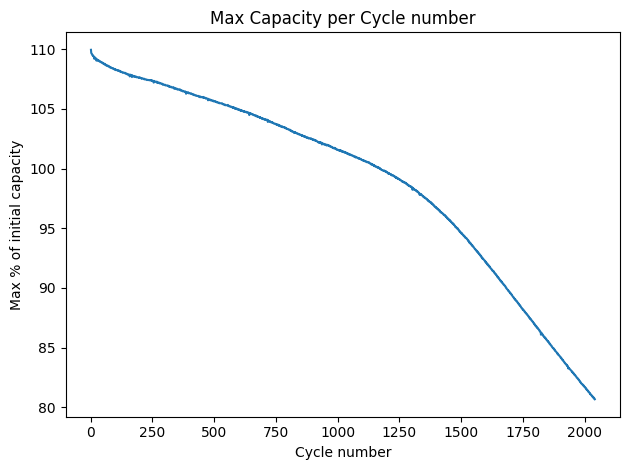

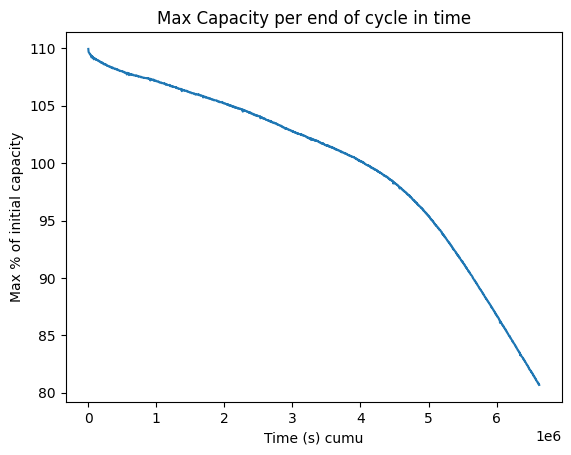

<Figure size 640x480 with 0 Axes>

100%|██████████| 2651/2651 [00:01<00:00, 1674.74it/s]


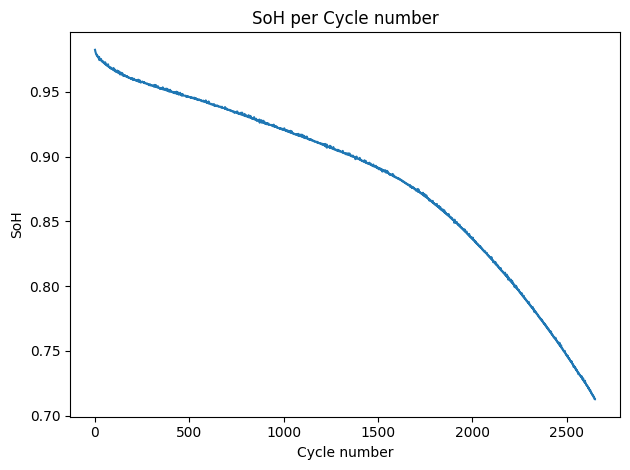

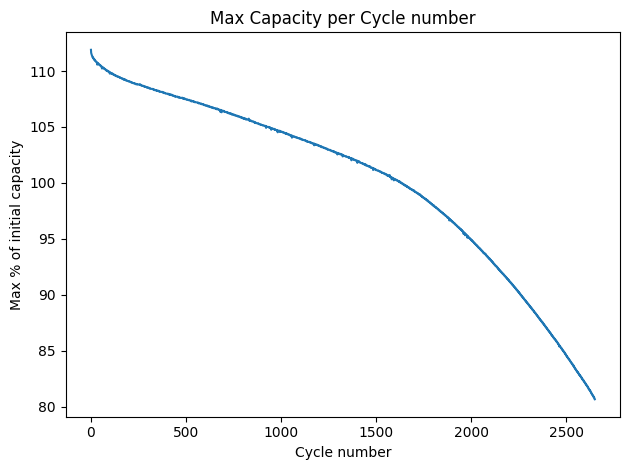

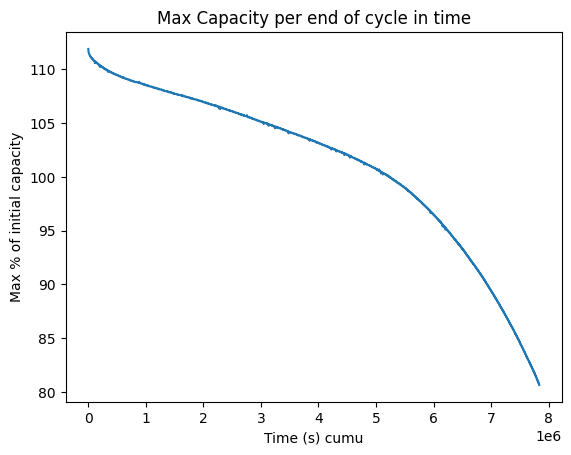

<Figure size 640x480 with 0 Axes>

 75%|███████▌  | 3/4 [00:19<00:06,  6.48s/it]


In [8]:
base_paths = 'csvs/'
original_files = [file.rstrip('.csv') for file in os.listdir(base_paths)]
os.makedirs('csv-summary/',exist_ok=True)
os.makedirs('capacity-fade-cno-plot/',exist_ok=True)
os.makedirs('capacity-fade-time-plot/',exist_ok=True)
os.makedirs('SoH-cno-plot/',exist_ok=True)
for file in tqdm(original_files):
    df_sample = pd.read_csv(base_paths+file+'.csv')
    
    cycle_data_list = []
    
    for cycle_number, group in tqdm(df_sample.groupby('Cycle number')):
        cycle_data = {
            'Time (s) cumu':group['Time (s) cumu'].max(),
            'Cycle number': cycle_number,
            'max_SOC': group['CC_SOC'].max(),
            'min_SOC': group['CC_SOC'].min(),
            'SoH' : (abs(group['CC_SOC'].max()) + abs(group['CC_SOC'].min()))/115, #normalize SoH by 115 to obtain values between 1 and 0.
            'max_voltage': group['Voltage (V)'].max(),
            'min_voltage': group['Voltage (V)'].min(),
            'mean_voltage': group['Voltage (V)'].mean(),
            'max_current': group['Current (mA)'].max(),
            'min_current': group['Current (mA)'].min(),
            'timetaken': group['Time (s)'].max() - group['Time (s)'].min(),
            'max_capacity': group['Capacity (mAh)'].max(),
            'min_capacity': group['Capacity (mAh)'].min(),
            'rul': int(group['rul'].mean()),  # Replace with your RUL calculation function
            #'Time (s) cumu':
        }
        cycle_data_list.append(cycle_data)
        
    df_cycle_data = pd.DataFrame(cycle_data_list)
    df_cycle_data['max_capacity_fade_rate'] = -(df_cycle_data['max_capacity'].diff() / df_cycle_data['Cycle number'].diff())

    df_cycle_data.to_csv('csv-summary/'+file+'.csv',index=False)
    
    # Create a figure with 5 vertical subplots
    plt.plot(df_cycle_data['Cycle number'], df_cycle_data['SoH'])
    
    # Add labels and title
    plt.xlabel('Cycle number')
    plt.ylabel('SoH')
    plt.title('SoH per Cycle number')
    
    # Add some spacing between plots
    plt.tight_layout()
    
    # You can also specify the DPI (dots per inch) for better resolution
    plt.savefig('SoH-cno-plot/'+file+'.png', dpi=300)
    # Display the plots
    plt.show()
    # Plot the line against time
    plt.plot(df_cycle_data['Cycle number'], df_cycle_data['max_SOC'])
    
    # Add labels and title
    plt.xlabel('Cycle number')
    plt.ylabel('Max % of initial capacity')
    plt.title('Max Capacity per Cycle number')
    
    # Add some spacing between plots
    plt.tight_layout()
    
    # You can also specify the DPI (dots per inch) for better resolution
    plt.savefig('capacity-fade-cno-plot/'+file+'.png', dpi=300)
    # Display the plots
    plt.show()

    # Create a figure with 5 vertical subplots
    # Plot the line against time
    plt.plot(df_cycle_data['Time (s) cumu'], df_cycle_data['max_SOC'])
    
    # Add labels and title
    plt.xlabel('Time (s) cumu')
    plt.ylabel('Max % of initial capacity')
    plt.title('Max Capacity per end of cycle in time')
    
    # Display the plot
    plt.show()
    # You can also specify the DPI (dots per inch) for better resolution
    plt.savefig('capacity-fade-time-plot/'+file+'.png', dpi=300)
    # Display the plots
    plt.show()
    if DEBUG:
        break_counter += 1
        if break_counter > 3:
            break_counter = 0
            break

# 3 b. Compute Gompertz parameters k,a and b

In [9]:
import random
choice = random.choice(original_files)
df = pd.read_csv("csv-summary/"+f'{choice}.csv')
df.head()

Time (s) cumu  Cycle number     max_SOC   min_SOC       SoH  max_voltage  \
0           3743             1  109.948459 -0.601951  0.961308       3.5996   
1           7383             2  109.708981 -0.730942  0.960347       3.5996   
2          11025             3  109.638622 -0.774923  0.960118       3.5999   
3          14664             4  109.623425 -0.764600  0.959896       3.5999   
4          18301             5  109.601074 -0.731417  0.959413       3.6002   

   min_voltage  mean_voltage  max_current  min_current  timetaken  \
0       1.9959      3.322919      5499.62     -3301.33       3743   
1       1.9788      3.305769      5500.00     -3301.33       3640   
2       1.9233      3.307168      5499.62     -3301.33       3642   
3       1.9001      3.307776      5499.62     -3301.71       3639   
4       1.9298      3.307660      5500.37     -3301.33       3637   

   max_capacity  min_capacity   rul  max_capacity_fade_rate  
0   1202.363093      0.000000  2041                     NaN  
1   1199.758951      0.000000  2040                2.604142  
2   1198.966418     -0.306871  2039                0.792533  
3   1198.810347     -0.171120  2038                0.156071  
4   1198.549991      0.000000  2037                0.260356

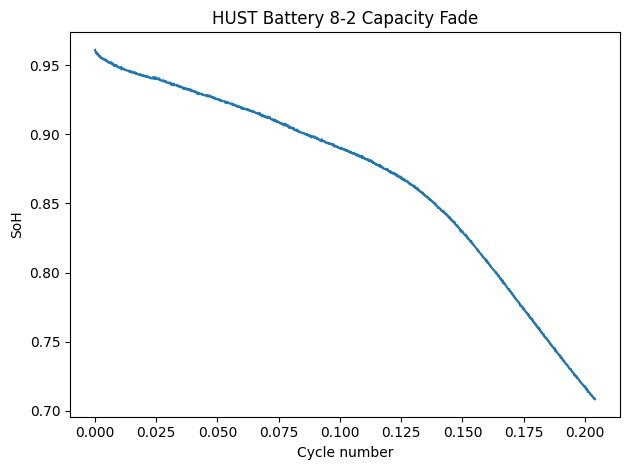

In [10]:
dataframes = df

# Create figure with subplots
fig = plt.figure()

plt.plot(df['Cycle number']/10000, ((df['SoH'])), label=f"Bat {choice}")

plt.xlabel('Cycle number')
plt.ylabel('SoH')
plt.title(f'HUST Battery {choice} Capacity Fade')

plt.tight_layout()
plt.show()

['3-6.csv', '9-8.csv', '8-2.csv', '2-2.csv']
list.remove(x): x not in list


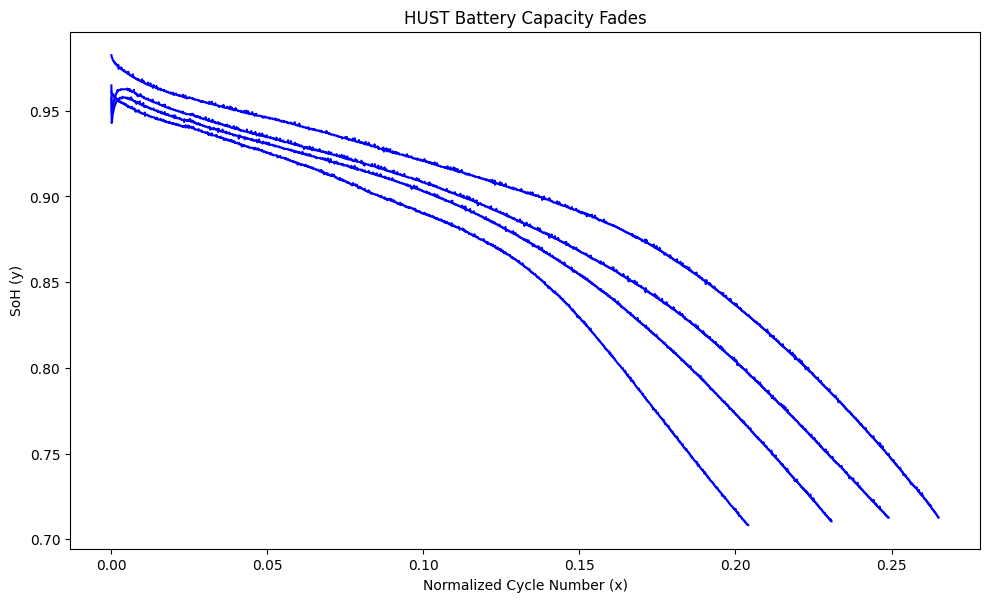

In [11]:
from matplotlib.gridspec import GridSpec

summary_path = 'csv-summary/'
files = os.listdir(summary_path)
print(files)
try:
    files.remove('1-8.csv')
except Exception as e:
    print(e)
# List of dataframes to plot
dataframes = [pd.read_csv(summary_path+file) for file in sorted(files)]
labels = [f'Battery {i+1}' for i in range(len(dataframes))]

# Create figure with subplots
fig = plt.figure(figsize=(10, 8))
gs = GridSpec(2, 1, height_ratios=[3, 1])  # Allocate space for the legend below

# Main plot on the first row
ax_main = fig.add_subplot(gs[0])
for i, df in enumerate(dataframes):
    ax_main.plot(df['Cycle number']/10000, df['SoH'], label=labels[i],color='blue')

# Set labels and title for the main plot
ax_main.set_xlabel('Normalized Cycle Number (x)')
ax_main.set_ylabel('SoH (y)')
ax_main.set_title('HUST Battery Capacity Fades')

plt.tight_layout()
plt.show()

['3-6.csv', '9-8.csv', '8-2.csv', '2-2.csv']
list.remove(x): x not in list


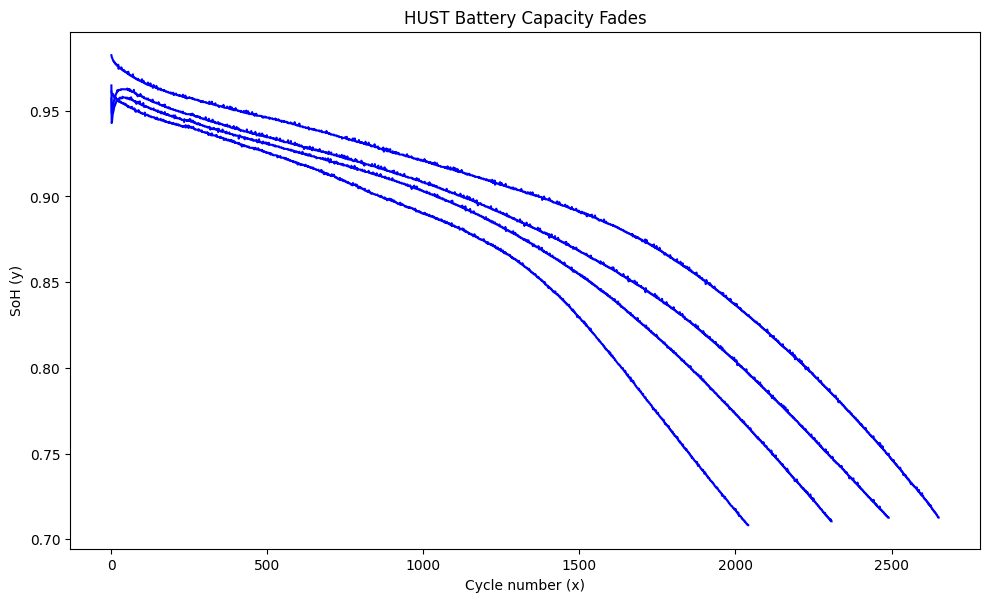

In [12]:
summary_path = 'csv-summary/'
files = os.listdir(summary_path)
print(files)
try:
    files.remove('1-8.csv')
except Exception as e:
    print(e)
# List of dataframes to plot
dataframes = [pd.read_csv(summary_path+file) for file in sorted(files)]
labels = [f'Battery {i+1}' for i in range(len(dataframes))]

# Create figure with subplots
fig = plt.figure(figsize=(10, 8))
gs = GridSpec(2, 1, height_ratios=[3, 1])  # Allocate space for the legend below

# Main plot on the first row
ax_main = fig.add_subplot(gs[0])
for i, df in enumerate(dataframes):
    ax_main.plot(df['Cycle number'], df['SoH'], label=labels[i],color='blue')

# Set labels and title for the main plot
ax_main.set_xlabel('Cycle number (x)')
ax_main.set_ylabel('SoH (y)')
ax_main.set_title('HUST Battery Capacity Fades')

plt.tight_layout()
plt.show()

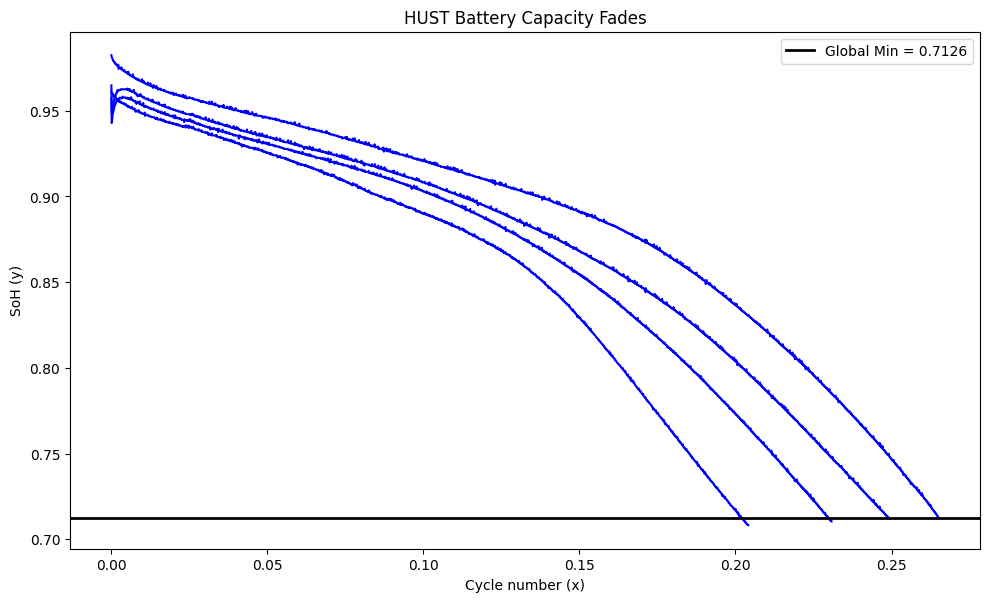

In [13]:
# Create figure with subplots
fig = plt.figure(figsize=(10, 8))
gs = GridSpec(2, 1, height_ratios=[3, 1])

# Main plot on the first row
ax_main = fig.add_subplot(gs[0])

# Variable to track the absolute lowest value seen across all dataframes
global_min_y = float('inf')
global_max_y = 0.0
for i, df in enumerate(dataframes):
    # Calculate x and y data
    x_val = df['Cycle number'] / 10000
    y_val = df['SoH']
    
    # Plot the curve
    ax_main.plot(x_val, y_val, color='blue')
    
    # --- ADDITION 1: Line for the last value of THIS curve ---
    last_y = y_val.iloc[-1]
    # Plots a dashed red line at the level of the last point
    #ax_main.axhline(y=last_y, color='red', linestyle='-', alpha=0.5, linewidth=1)
    
    # Check for global min
    current_min = y_val.min()
    if current_min < global_min_y:
        global_min_y = current_min
    current_max = y_val.min()
    if current_max > global_max_y:
        global_max_y = current_max
# --- ADDITION 2: Line for the LOWEST overall value ---
#ax_main.axhline(y=global_max_y, color='red', linestyle='-', alpha=0.5, linewidth=1)
# Plots a solid black line at the lowest point found in all data
ax_main.axhline(y=global_max_y, color='black', linestyle='-', linewidth=2, label=f'Global Min = {global_max_y:.4f}')

# Set labels and title for the main plot
ax_main.set_xlabel('Cycle number (x)')
ax_main.set_ylabel('SoH (y)')
ax_main.set_title('HUST Battery Capacity Fades')

# Add a legend to explain the black line
ax_main.legend()

plt.tight_layout()
plt.show()

# 3 c. Compute Gompertz parameters k,a and b

In [14]:
csvs = os.listdir('csv-summary')
def gompertz_func(x,k,a,b):
    return k*np.exp(-np.exp(a-(b*x)))

In [15]:
from scipy.optimize import minimize

In [16]:
csv_choosen = random.choice(csvs)

df = pd.read_csv("csv-summary/"+csv_choosen)

x_data = np.array(df['Cycle number']/10000) # Independent variable
d_data = np.array(((df['SoH']))) # Observed dependent variable

# Define the loss function
def loss_function(params, x, d):
    k , a, b = params  # Parameters to optimize
    predicted_d = gompertz_func(x,k,a,b) # Equation model
    return np.sum((predicted_d - d) ** 2)  # Minimize squared error

# Initial guess for a, b, c
initial_guess = [1, 1, 1]

# Perform optimization
result = minimize(loss_function, initial_guess, args=(x_data, d_data))

# Optimized values of a, b, c
op_k, op_a, op_b = result.x
print(csv_choosen)
print(f"k = {op_k}, a = {op_a}, b = {op_b}")
print(f"The Gompertz value : {gompertz_func(x=x_data,k=op_k,a=op_a,b=op_b)}")

9-8.csv
k = 0.9793519535954114, a = -3.56671912868596, b = -10.580379433287561
The Gompertz value : [0.95204547 0.95201697 0.95198844 ... 0.70828713 0.70804421 0.70780111]


In [17]:
data= []
for csv_choosen in csvs:
    
    df = pd.read_csv("csv-summary/"+csv_choosen)
    ## Independent variable
    x_data = np.array(df['Cycle number']/10000)    # Independent variable

    d_data = np.array(((df['SoH'])))   # Observed dependent variable
    # normalization was (df['SoH'].max()-80), using 115 to standardize all cells
    # Define the loss function
    def loss_function(params, x, d):
        k , a, b = params  # Parameters to optimize
        predicted_d = gompertz_func(x,k,a,b) # Equation model
        return np.sum((predicted_d - d) ** 2)  # Minimize squared error
    
    # Initial guess for a, b, c
    initial_guess = [1, 1, 1]
    
    # Perform optimization
    result = minimize(loss_function, initial_guess, args=(x_data, d_data))
    
    # Optimized values of a, b, c
    op_k, op_a, op_b = result.x
    #print(csv_choosen)
    #print(f"k = {op_k}, a = {op_a}, b = {op_b}")
    data.append({'file':csv_choosen,'k':op_k,'a':op_a,'b':op_b,'rul':len(df['Cycle number']),'SoH_above_80':(df['SoH'].max()-0.80),'SoH':(df['SoH'].max()),'norm_SoH':((df['SoH'].max()))})

gompertz_df = pd.DataFrame(data)

gompertz_df.to_csv('hust_gompertz_params.csv', index=False)  

gompertz_df.head()

file         k         a          b   rul  SoH_above_80       SoH  \
0  3-6.csv  0.985113 -3.474963  -9.437823  2491      0.164810  0.964810   
1  9-8.csv  0.979352 -3.566719 -10.580379  2308      0.158209  0.958209   
2  8-2.csv  0.970015 -3.770241 -12.932055  2041      0.161308  0.961308   
3  2-2.csv  0.983328 -3.811998 -10.046907  2651      0.182448  0.982448   

   norm_SoH  
0  0.964810  
1  0.958209  
2  0.961308  
3  0.982448

In [18]:
gompertz_df['gompertz-value'] = gompertz_func(x=gompertz_df['rul']/10000,k=gompertz_df['k'],a=gompertz_df['a'],b=gompertz_df['b'])
gompertz_df['gompertz-1st-derivative-value']=gompertz_df['b']*gompertz_func(x=gompertz_df['rul']/10000,k=gompertz_df['k'],a=gompertz_df['a'],b=gompertz_df['b'])*np.exp(gompertz_df['a'] - (gompertz_df['b'] * gompertz_df['rul']/10000))
gompertz_df['gompertz-2nd-derivative-value']=gompertz_df['b']**2*gompertz_func(x=gompertz_df['rul']/10000,k=gompertz_df['k'],a=gompertz_df['a'],b=gompertz_df['b'])*np.exp(gompertz_df['a'] - (gompertz_df['b'] * gompertz_df['rul']/10000))*(np.exp(gompertz_df['a'] - (gompertz_df['b'] * gompertz_df['rul']/10000)-1))

In [19]:
gompertz_df = gompertz_df.sort_values(by='rul').reset_index(drop=True)

<Axes: >

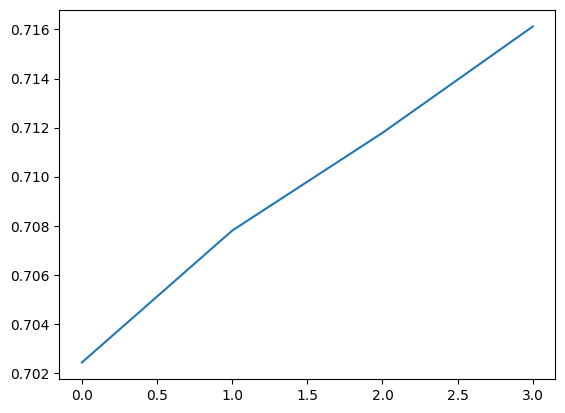

In [20]:
gompertz_df['gompertz-value'].plot()

<Axes: >

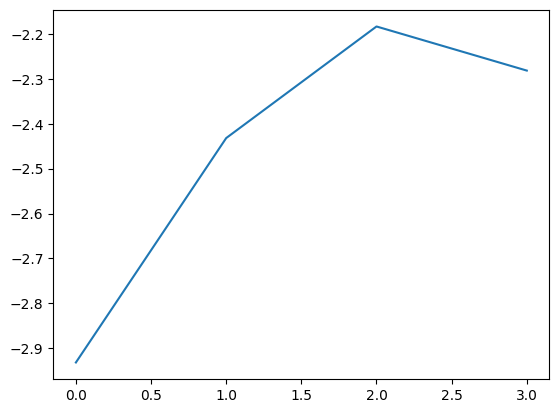

In [21]:
gompertz_df['gompertz-1st-derivative-value'].plot()

<Axes: >

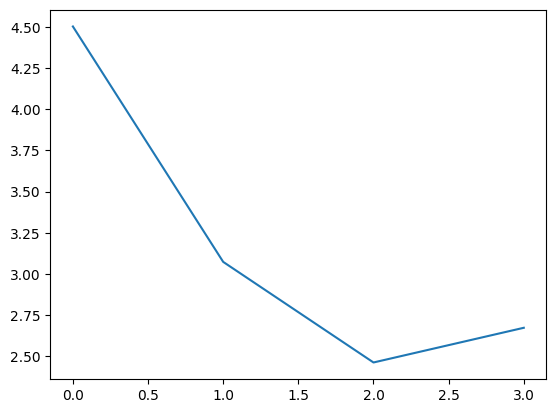

In [22]:
gompertz_df['gompertz-2nd-derivative-value'].plot()

In [23]:
gompertz_df.iloc[:,1:].corr()

k         a         b       rul  \
k                              1.000000  0.456677  0.994970  0.923235   
a                              0.456677  1.000000  0.530219  0.079833   
b                              0.994970  0.530219  1.000000  0.886155   
rul                            0.923235  0.079833  0.886155  1.000000   
SoH_above_80                   0.465795 -0.560184  0.380548  0.762809   
SoH                            0.465795 -0.560184  0.380548  0.762809   
norm_SoH                       0.465795 -0.560184  0.380548  0.762809   
gompertz-value                 0.895645  0.013348  0.853072  0.997745   
gompertz-1st-derivative-value  0.998089  0.488608  0.998821  0.907601   
gompertz-2nd-derivative-value -0.996212 -0.475385 -0.997572 -0.911415   

                               SoH_above_80       SoH  norm_SoH  \
k                                  0.465795  0.465795  0.465795   
a                                 -0.560184 -0.560184 -0.560184   
b                                  0.380548  0.380548  0.380548   
rul                                0.762809  0.762809  0.762809   
SoH_above_80                       1.000000  1.000000  1.000000   
SoH                                1.000000  1.000000  1.000000   
norm_SoH                           1.000000  1.000000  1.000000   
gompertz-value                     0.804080  0.804080  0.804080   
gompertz-1st-derivative-value      0.424536  0.424536  0.424536   
gompertz-2nd-derivative-value     -0.429979 -0.429979 -0.429979   

                               gompertz-value  gompertz-1st-derivative-value  \
k                                    0.895645                       0.998089   
a                                    0.013348                       0.488608   
b                                    0.853072                       0.998821   
rul                                  0.997745                       0.907601   
SoH_above_80                         0.804080                       0.424536   
SoH                                  0.804080                       0.424536   
norm_SoH                             0.804080                       0.424536   
gompertz-value                       1.000000                       0.877389   
gompertz-1st-derivative-value        0.877389                       1.000000   
gompertz-2nd-derivative-value       -0.881791                      -0.999314   

                               gompertz-2nd-derivative-value  
k                                                  -0.996212  
a                                                  -0.475385  
b                                                  -0.997572  
rul                                                -0.911415  
SoH_above_80                                       -0.429979  
SoH                                                -0.429979  
norm_SoH                                           -0.429979  
gompertz-value                                     -0.881791  
gompertz-1st-derivative-value                      -0.999314  
gompertz-2nd-derivative-value                       1.000000

# 3 d. Visualize Gompertz parameters k,a and b & battery values

In [24]:
bins = [1000, 1500, 2000, 4000]
labels = ['>1000', '>1500', '>2000']

# 3. Create the Category Column
# right=False ensures 2000 falls into '2000s', not '1000s'
gompertz_df['rul_category'] = pd.cut(gompertz_df['rul'], bins=bins, labels=labels, right=False)

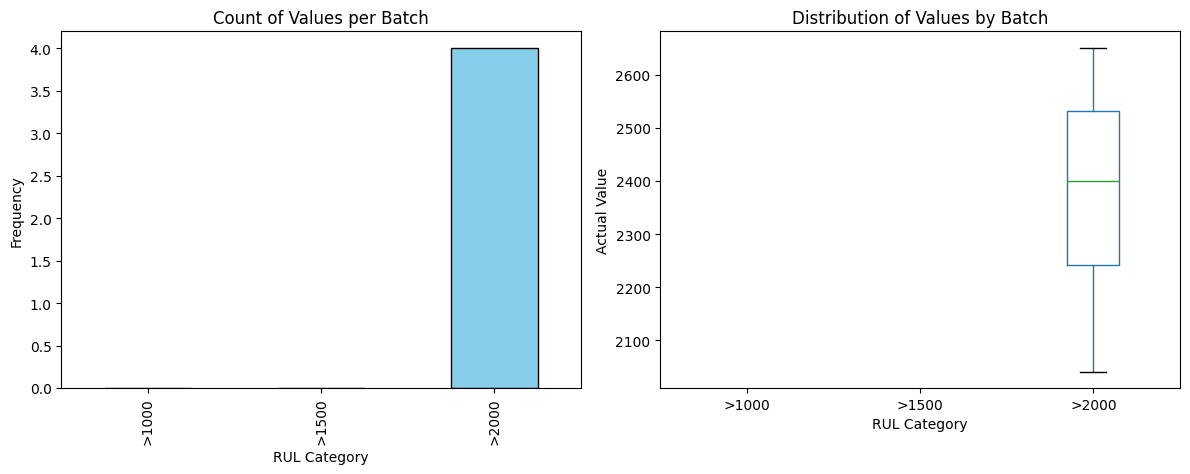

In [25]:
# 4. Plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot A: How many items are in each batch? (Bar Chart)
counts = gompertz_df['rul_category'].value_counts().sort_index()
counts.plot(kind='bar', ax=axes[0], color='skyblue', edgecolor='black')
axes[0].set_title('Count of Values per Batch')
axes[0].set_ylabel('Frequency')
axes[0].set_xlabel('RUL Category')
# Plot B: What are the values inside each batch? (Box Plot)
gompertz_df.boxplot(column='rul', by='rul_category', ax=axes[1], grid=False)
axes[1].set_title('Distribution of Values by Batch')
axes[1].set_ylabel('Actual Value')
axes[1].set_xlabel('RUL Category')
plt.suptitle('') # Clean up default pandas title

plt.tight_layout()
plt.savefig('category_plots.png')
plt.show()

In [26]:
gompertz_df['>=2000 rul'] = gompertz_df['rul'] >= 2000

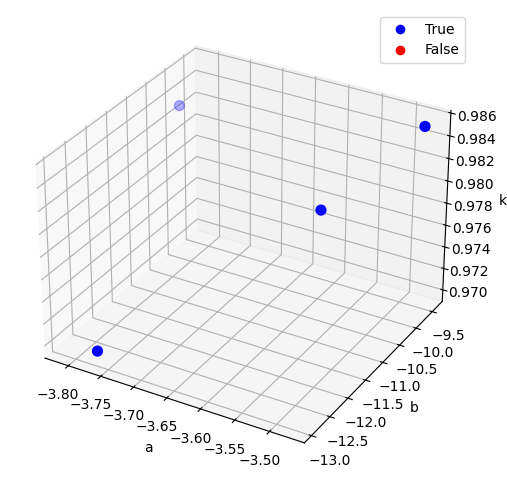

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Example data
x = np.array(gompertz_df['a'])
y = np.array(gompertz_df['b'])
z = np.array(gompertz_df['k'])
binary_values = np.array(gompertz_df['>=2000 rul'])  # Binary column

# Map True/False to colors
colors = np.where(binary_values, 'blue', 'red')  # True = blue, False = red

# Create a 3D figure
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot points with discrete colors
sc = ax.scatter(x, y, z, c=colors, s=50)

# Labels
ax.set_xlabel("a")
ax.set_ylabel("b")
ax.set_zlabel("k")

# Add a legend manually
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', label='True', markersize=8, markerfacecolor='blue'),
                   Line2D([0], [0], marker='o', color='w', label='False', markersize=8, markerfacecolor='red')]
ax.legend(handles=legend_elements, loc='best')

# Show the plot
plt.show()

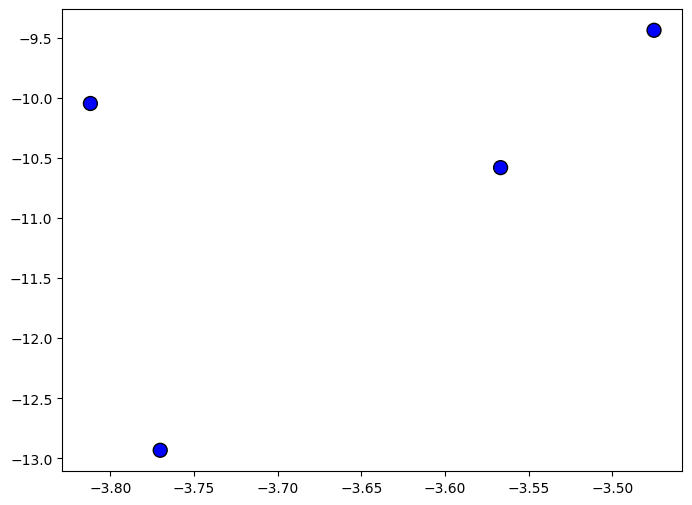

In [28]:
x = np.array(gompertz_df['a'])
y = np.array(gompertz_df['b'])
#z = np.array(gompertz_df['k'])
binary_values = np.array(gompertz_df['>=2000 rul'])  # Binary column

# Map True/False to colors
colors = np.where(binary_values, 'blue', 'red')  # True = blue, False = red

# Create 2D scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(x, y, c=colors, s=100, edgecolors='black')

# Labels
ax.set_xlabel("a")
ax.set_ylabel("b")
ax.set_title("2D Scatter Plot with Binary Coloring")#title("2D Scatter Plot with Binary Coloring")

# Add a legend manually
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', label='True', markersize=10, markerfacecolor='blue'),
                   Line2D([0], [0], marker='o', color='w', label='False', markersize=10, markerfacecolor='red')]

ax.legend(handles=legend_elements, loc='best')

# Show plot
plt.show()

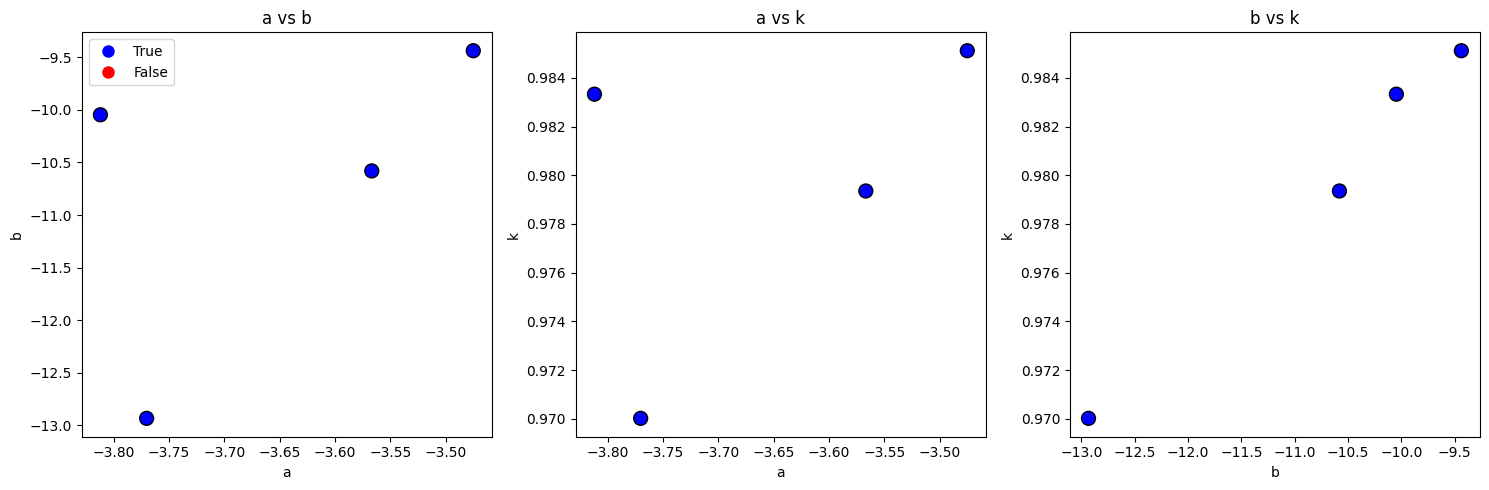

In [29]:
x = np.array(gompertz_df['a'])
y = np.array(gompertz_df['b'])
z = np.array(gompertz_df['k'])
binary_values = np.array(gompertz_df['>=2000 rul'])  # Binary column

# Map True/False to colors
colors = np.where(binary_values, 'blue', 'red')  # True = blue, False = red

# Create figure and subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Subplot 1: X vs Y
axes[0].scatter(x, y, c=colors, s=100, edgecolors='black')
axes[0].set_xlabel("a")
axes[0].set_ylabel("b")
axes[0].set_title("a vs b")

# Subplot 2: X vs Z
axes[1].scatter(x, z, c=colors, s=100, edgecolors='black')
axes[1].set_xlabel("a")
axes[1].set_ylabel("k")
axes[1].set_title("a vs k")

# Subplot 3: Y vs Z
axes[2].scatter(y, z, c=colors, s=100, edgecolors='black')
axes[2].set_xlabel("b")
axes[2].set_ylabel("k")
axes[2].set_title("b vs k")

# Add a legend manually (only in the first subplot)
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', label='True', markersize=10, markerfacecolor='blue'),
                   Line2D([0], [0], marker='o', color='w', label='False', markersize=10, markerfacecolor='red')]
axes[0].legend(handles=legend_elements, loc='best')

# Adjust layout
plt.tight_layout()
plt.show()

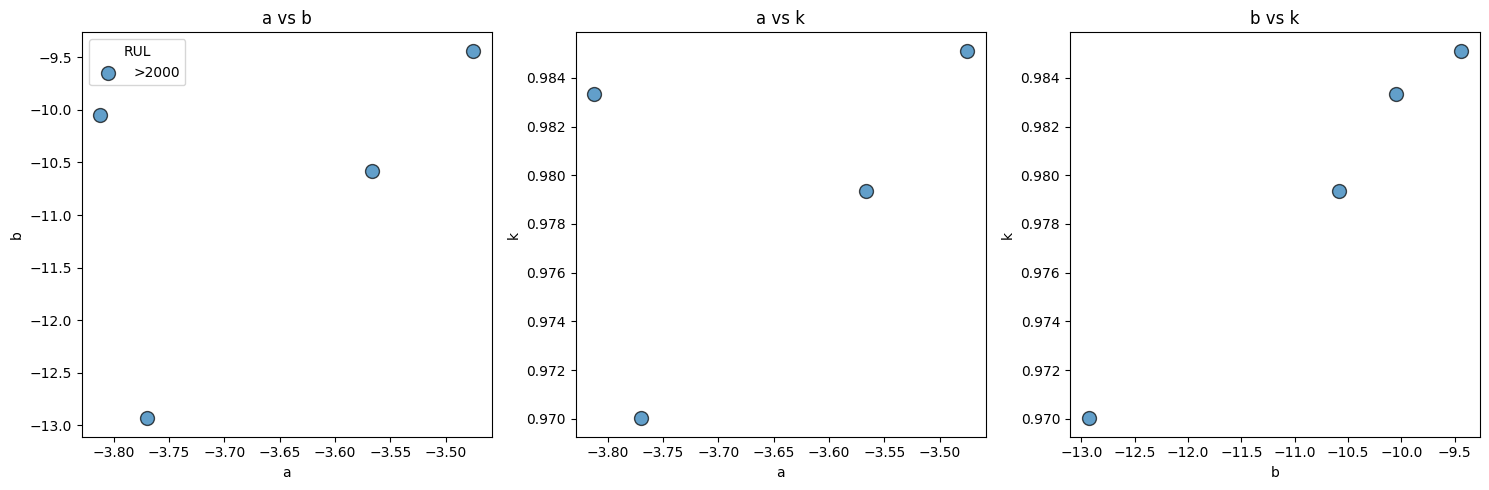

In [30]:
# 1. Define the pairs of columns you want to plot for each subplot
# Format: (subplot_index, x_column_name, y_column_name)
plot_pairs = [
    (0, 'a', 'b'),
    (1, 'a', 'k'),
    (2, 'b', 'k')
]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 2. Loop through each subplot configuration
for ax_idx, x_col, y_col in plot_pairs:
    ax = axes[ax_idx]
    
    # 3. Group by category and plot each chunk
    # This automatically assigns a different color to each category
    # 'observed=True' handles cases where some categories might be empty
    for name, group in gompertz_df.groupby('rul_category', observed=True):
        ax.scatter(
            group[x_col], 
            group[y_col], 
            label=name,         # Uses the category name for the legend
            s=100, 
            edgecolors='black', 
            alpha=0.7           # Adds transparency
        )

    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    ax.set_title(f"{x_col} vs {y_col}")

# 4. Add the legend (only needed on the first plot to avoid clutter)
axes[0].legend(title="RUL", loc='best')

plt.tight_layout()
plt.show()

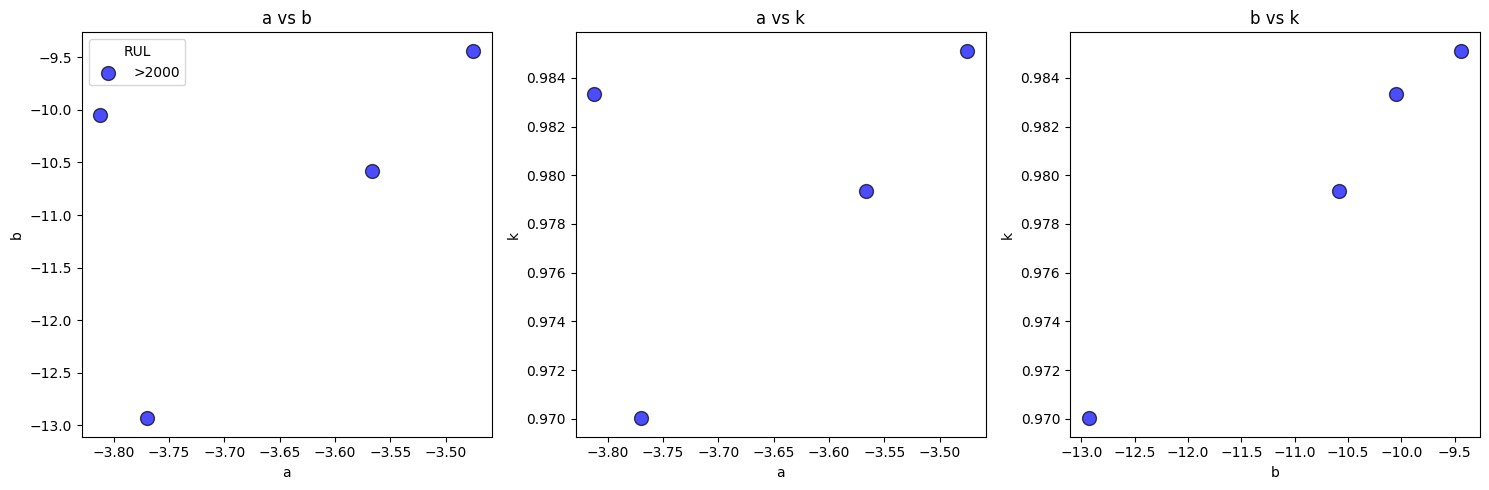

In [31]:
# 1. Define your specific colors here
# Keys must match the labels you created in pd.cut
color_map = {
    '>1000': 'red', 
    '>2000': 'blue', 
    '>1500': 'green'
}

# 2. Define the plot pairs (Subplot Index, X Col, Y Col)
plot_pairs = [
    (0, 'a', 'b'),
    (1, 'a', 'k'),
    (2, 'b', 'k')
]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax_idx, x_col, y_col in plot_pairs:
    ax = axes[ax_idx]
    
    # Group by category so we can control color per group
    for name, group in gompertz_df.groupby('rul_category', observed=True):
        
        # Select color based on the group name
        # .get(name, 'gray') is a fallback in case a category is missing from the map
        specific_color = color_map.get(name, 'gray')
        
        ax.scatter(
            group[x_col], 
            group[y_col], 
            label=name, 
            c=specific_color,      # <--- Apply the specific color here
            s=100, 
            edgecolors='black',    # Keep the black border for contrast
            alpha=0.7
        )

    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    ax.set_title(f"{x_col} vs {y_col}")

# Add legend
axes[0].legend(title="RUL", loc='best')

plt.tight_layout()
plt.show()

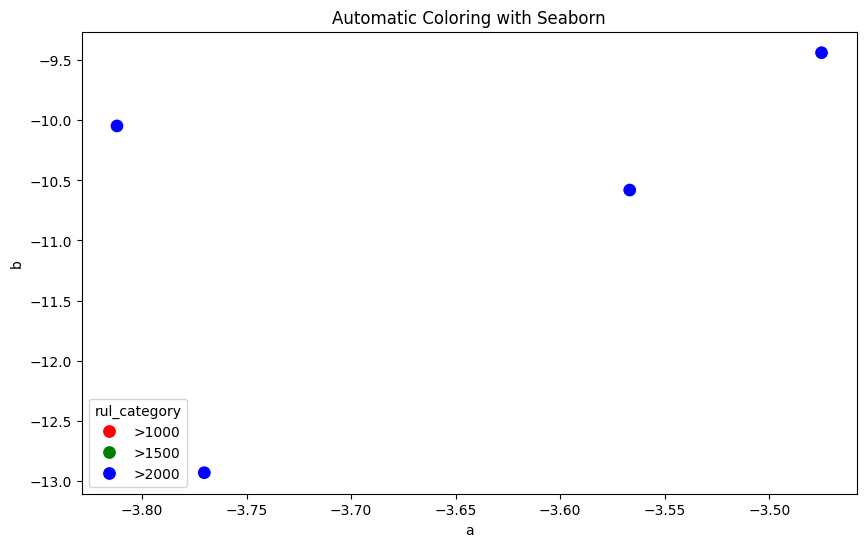

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

# ... (Assume df is created as above)

plt.figure(figsize=(10, 6))

# The 'hue' parameter does exactly what you want automatically
sns.scatterplot(data=gompertz_df, x='a', y='b', hue='rul_category', palette=color_map, s=100)

plt.title("Automatic Coloring with Seaborn")
plt.show()

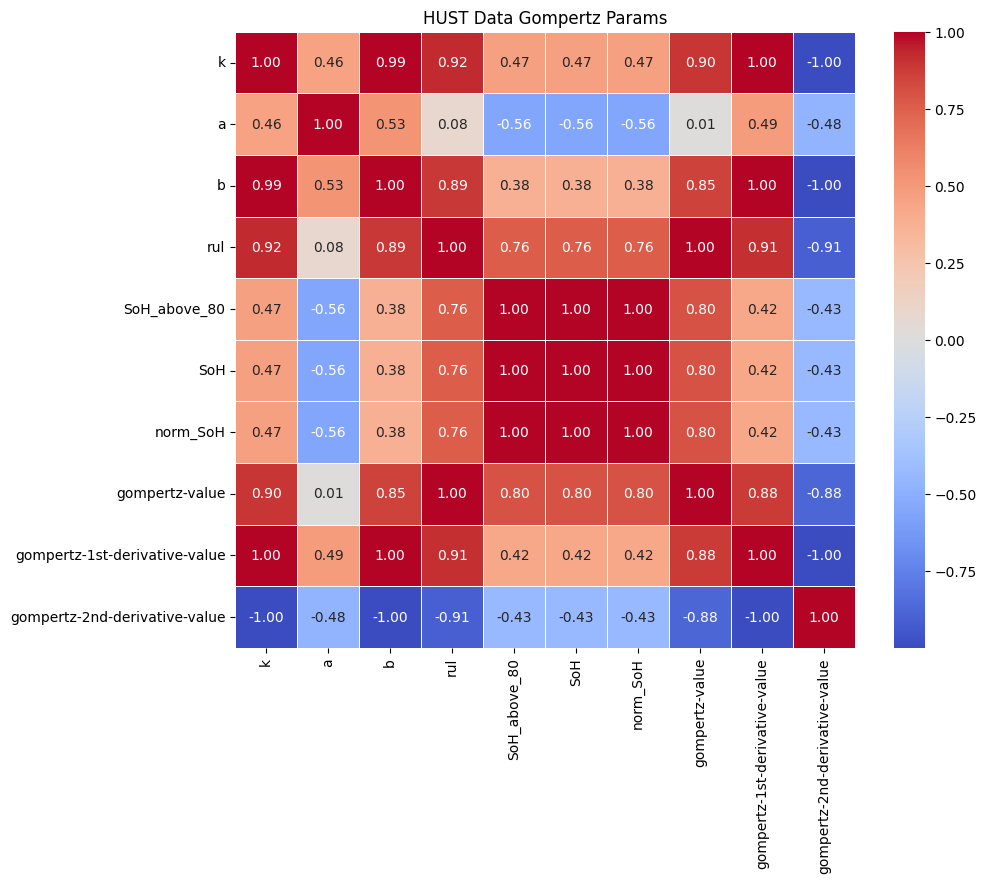

In [33]:
# Compute the correlation matrix
corr_matrix = gompertz_df.iloc[:, 1:-2].corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("HUST Data Gompertz Params")
plt.show()

# 3 e. Compute gompertz parameters at multiple cycle intervals for gompertz model

In [34]:
os.makedirs('gompertz-parameters-per-cycle/',exist_ok=True)
count = 0
for csv_choosen in csvs:
    data= []
    #csv_choosen = random.choice(csvs)
    
    df_full = pd.read_csv("csv-summary/"+csv_choosen)
    rul_value = len(df_full['Cycle number']) 
    print(rul_value)
    for i in range(1,rul_value+1):
        df = df_full.iloc[0:i]
        # Example dataset (x values and corresponding observed d values)
        # x_data = np.array(df['Cycle number']/len(df['Cycle number']))#df['Cycle number'].to_list()) #np.array([0,1, 2, 3, 4, 5])  # Independent variable
        x_data = np.array(df['Cycle number']/10000)#df['Cycle number'].to_list()) #np.array([0,1, 2, 3, 4, 5])  # Independent variable
    
        d_data = np.array((df['SoH']))#(df['SoH'].max()-80)))#df['max_SOC'].to_list())#np.array([1,2.7, 7.4, 20.1, 54.6, 148.4])  # Observed dependent variable
        
        # Define the loss function
        def loss_function(params, x, d):
            k , a, b = params  # Parameters to optimize
            predicted_d = gompertz_func(x,k,a,b) # Equation model
            return np.sum((predicted_d - d) ** 2)  # Minimize squared error
        
        # Initial guess for a, b, c
        initial_guess = [1, 1, 1]
        
        # Perform optimization
        result = minimize(loss_function, initial_guess, args=(x_data, d_data))
        
        # Optimized values of a, b, c
        op_k, op_a, op_b = result.x
        #print(csv_choosen)
        #print(f"k = {op_k}, a = {op_a}, b = {op_b}")
        data.append({'Cycle number':i,'k':op_k,'a':op_a,'b':op_b,'rul':rul_value-i+1,'max_SoC_above_80':(df['max_SOC'].max()-80),'SoH':df.loc[i-1,'SoH'],'gompertz-value': gompertz_func(x=(rul_value-i+1)/10000,k=op_k,a=op_a,b=op_b),'gompertz-1st-derivative-value':(op_b*gompertz_func(x=(rul_value-i+1)/10000,k=op_k,a=op_a,b=op_b)*np.exp(op_a - (op_b * (rul_value-i+1)/10000))),'gompertz-2nd-derivative-value':(op_b**2*gompertz_func(x=(rul_value-i+1)/10000,k=op_k,a=op_a,b=op_b)*np.exp(op_a - (op_b * (rul_value-i+1)/10000))*(np.exp(op_a - (op_b * (rul_value-i+1)/10000))-1))}) #,'simplified-gompertz-1st-derivative-value':(-1*op_b*gompertz_func(x=(rul_value-i+1)/10000,k=op_k,a=op_a,b=op_b)*np.log(gompertz_func(x=(rul_value-i+1)/10000,k=op_k,a=op_a,b=op_b)/op_k))
    
    gompertz_df = pd.DataFrame(data)
    
    gompertz_df.to_csv(f"gompertz-parameters-per-cycle/{csv_choosen.split('.')[0]}-hust_gompertz_params.csv", index=False)
    count += 1
    #break
    # if count == 4:
    #     break

2491
2308
2041
2651


<Axes: >

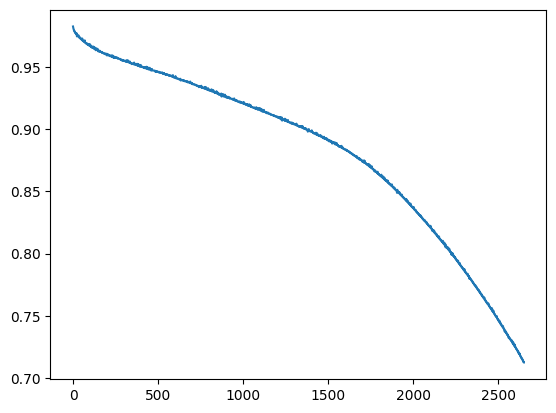

In [35]:
gompertz_df['SoH'].plot()

<Axes: >

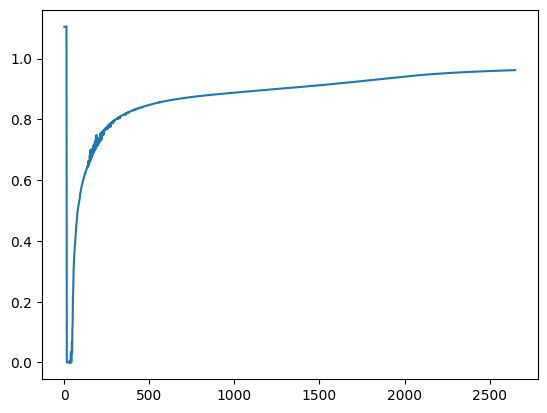

In [36]:
gompertz_df['gompertz-value'].plot()

<Axes: >

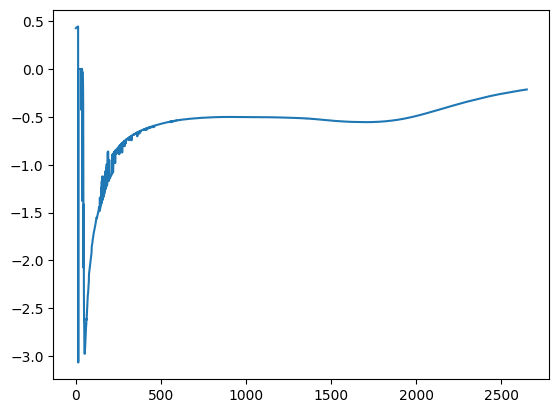

In [37]:
gompertz_df['gompertz-1st-derivative-value'].plot()

<Axes: >

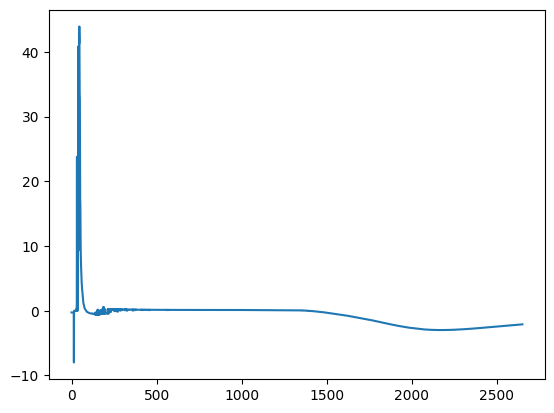

In [38]:
gompertz_df['gompertz-2nd-derivative-value'].plot()

# 4.  Visualize per cycle y, dy/dx and d2y/dx2

In [39]:
import re

files = os.listdir("csv-summary")
#Filter out non-csv files, folders or csv that don't start with a digit

filtered = [f for f in files if re.match(r'^\d', f) and f.endswith('.csv')]

print(len(filtered))

pairs = [re.match(r'^(\d+-\d+)', f).group(1) for f in filtered]

print(pairs)

4
['3-6', '9-8', '8-2', '2-2']


   Cycle number         k         a         b   rul  max_SoC_above_80  \
0             1  1.615486 -0.655571  1.000166  2041         29.948459   
1             2  1.618522 -0.650946  1.000248  2040         29.948459   
2             3  1.622358 -0.645897  1.000329  2039         29.948459   
3             4  1.625296 -0.642056  1.000410  2038         29.948459   
4             5  1.627903 -0.638569  1.000490  2037         29.948459   

        SoH  gompertz-value  gompertz-1st-derivative-value  \
0  0.961308        1.057967                       0.447898   
1  0.960347        1.057840                       0.449994   
2  0.960118        1.058029                       0.452427   
3  0.959896        1.058165                       0.454302   
4  0.959413        1.058236                       0.455994   

   gompertz-2nd-derivative-value  
0                      -0.258351  
1                      -0.258683  
2                      -0.259112  
3                      -0.259443  
4            

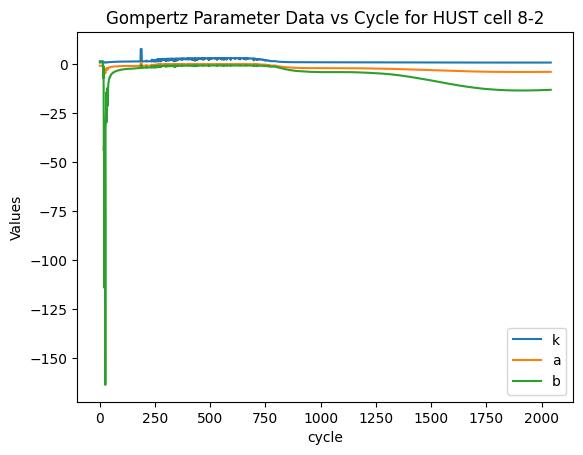

In [40]:
base_path = 'gompertz-parameters-per-cycle/'

choice = random.choice(pairs)

gompertz_df_full = pd.read_csv(base_path+choice+"-hust_gompertz_params.csv")
print(gompertz_df_full.head())
# Plot multiple columns vs Time on one plot
y_columns = ["k","a","b"]#,'rul']#,"rul"]  # choose the columns to plot

for col in y_columns:
    # plt.plot(gompertz_df["cycle"], gompertz_df[col], label=col)
    plt.plot(gompertz_df_full["Cycle number"], gompertz_df_full[col], label=col)

plt.xlabel("cycle")
plt.ylabel("Values")
# Use log scale on y-axis (common in battery/fade plots)
#plt.yscale("log")
plt.title(f"Gompertz Parameter Data vs Cycle for HUST cell {choice}")
plt.legend()
plt.show()

      Cycle number         k         a          b  rul  max_SoC_above_80  \
2036          2037  0.969898 -3.774004 -12.951971    5         29.948459   
2037          2038  0.969926 -3.773085 -12.947104    4         29.948459   
2038          2039  0.969956 -3.772123 -12.942013    3         29.948459   
2039          2040  0.969985 -3.771206 -12.937156    2         29.948459   
2040          2041  0.970015 -3.770241 -12.932055    1         29.948459   

           SoH  gompertz-value  gompertz-1st-derivative-value  \
2036  0.708678        0.947741                      -0.283667   
2037  0.708681        0.947777                      -0.283464   
2038  0.708680        0.947814                      -0.283269   
2039  0.708197        0.947850                      -0.283066   
2040  0.708194        0.947887                      -0.282873   

      gompertz-2nd-derivative-value  
2036                      -3.589143  
2037                      -3.585259  
2038                      -3.581410  


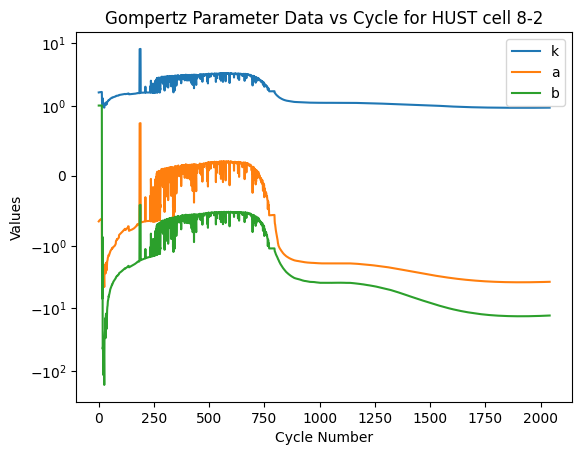

In [41]:
os.makedirs('Parameter-Plots/',exist_ok=True)
print(gompertz_df_full.tail())
# Plot multiple columns vs Time on one plot
y_columns = ["k","a","b"]#,'rul']#,"rul"]  # choose the columns to plot

for col in y_columns:
    # plt.plot(gompertz_df["cycle"], gompertz_df[col], label=col)
    plt.plot(gompertz_df_full["Cycle number"], gompertz_df_full[col], label=col)

plt.xlabel("Cycle Number")
plt.ylabel("Values")
# Use log scale on y-axis (common in battery/fade plots)
#plt.yscale("log")
plt.yscale('symlog', linthresh=1)
plt.title(f"Gompertz Parameter Data vs Cycle for HUST cell {choice}")
plt.legend()
plt.savefig(f"Parameter-Plots/HUST-cell-{choice}.png",dpi=300,format='png')
plt.show()

In [42]:
cycle_lengths = []
cycle_lengths_sort = {}
#Correlation of k, a and b with cycle number
##Place k, a and b of all cells in all cycles in one dataframe
for choice in pairs:
    gompertz_df_full = pd.read_csv(base_path + choice + "-hust_gompertz_params.csv")
    cycle_lengths.append(gompertz_df_full.shape[0])
    cycle_lengths_sort[choice] = gompertz_df_full.shape[0]
print(f"Max : {max(cycle_lengths)}, Min : {min(cycle_lengths)}")


#sort pairs by RUL
pairs = sorted(cycle_lengths_sort, key=cycle_lengths_sort.get)
print(pairs)

Max : 2651, Min : 2041
['8-2', '9-8', '3-6', '2-2']


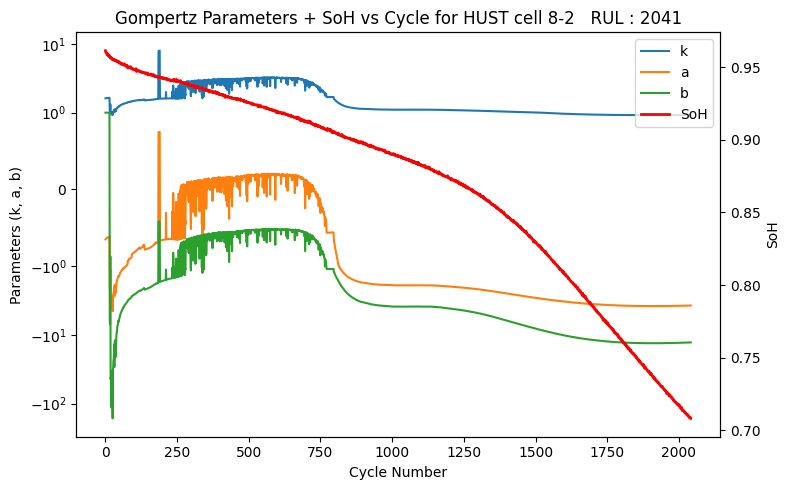

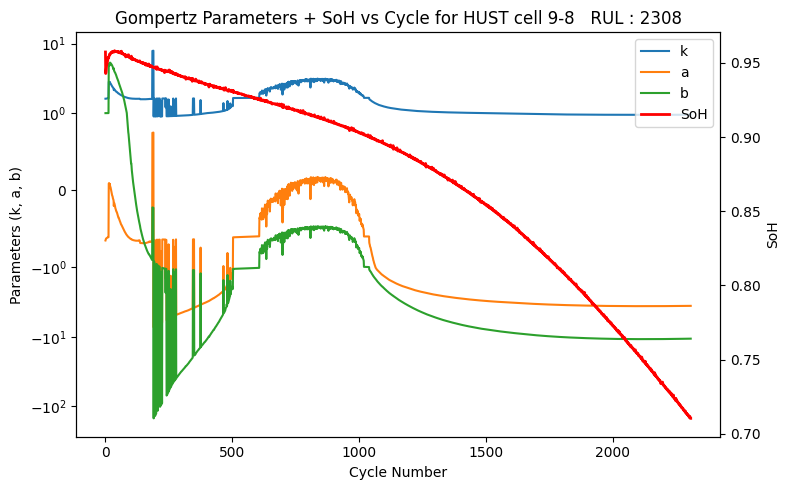

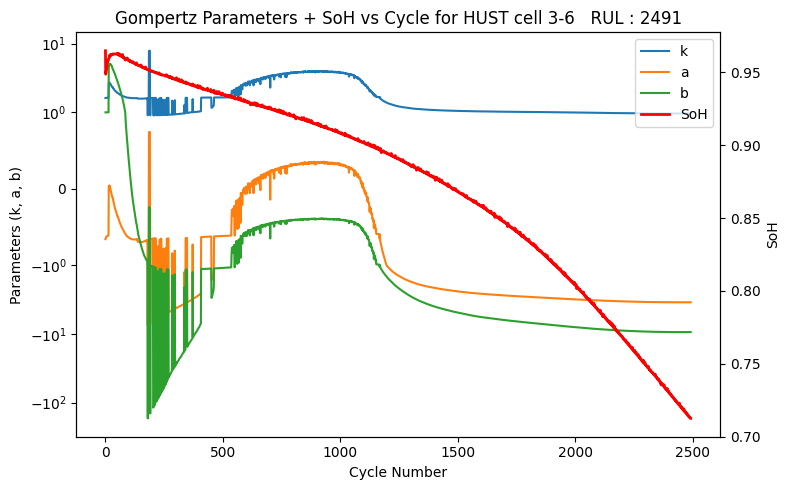

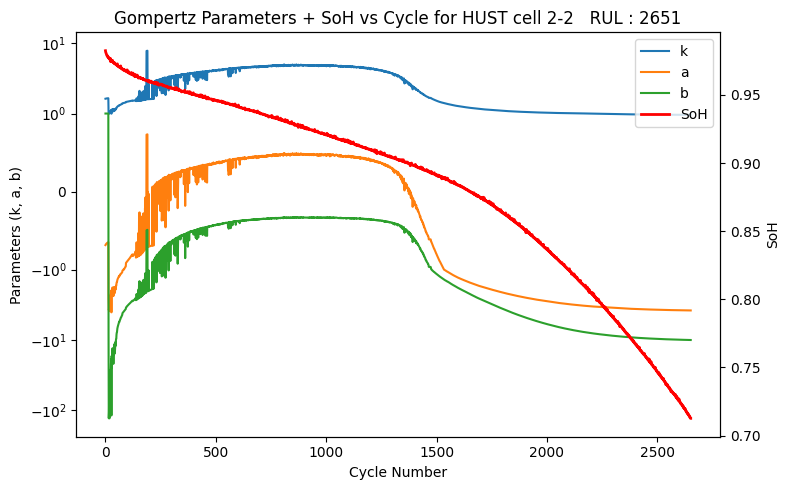

In [43]:
for choice in pairs:
    gompertz_df_full = pd.read_csv(base_path + choice + "-hust_gompertz_params.csv")
    
    plt.figure(figsize=(8, 5))

    x = gompertz_df_full["Cycle number"]
    
    # --- Left axis ---
    ax1 = plt.gca()
    for col in ["k", "a", "b"]:
        ax1.plot(x, gompertz_df_full[col], label=col)
    
    ax1.set_xlabel("Cycle Number")
    ax1.set_ylabel("Parameters (k, a, b)")
    ax1.set_yscale('symlog', linthresh=1)
    
    # --- Right axis ---
    ax2 = ax1.twinx()
    ax2.plot(x, gompertz_df_full["SoH"], color="red", label="SoH", linewidth=2)
    ax2.set_ylabel("SoH")
    
    # --- Title ---
    plt.title(f"Gompertz Parameters + SoH vs Cycle for HUST cell {choice}   RUL : {cycle_lengths_sort[choice]}")
    
    # --- Combined legend ---
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper right")
    
    plt.tight_layout()
    plt.savefig(f"Parameter-Plots/HUST-cell-{choice}-Two-Y.png", dpi=300)
    plt.show()

    #break

In [44]:
unified_gompertz = {}
for choice in pairs:
    #get file
    gompertz_df_full = pd.read_csv(base_path + choice + "-hust_gompertz_params.csv")
    #add cell name
    gompertz_df_full['cell_name'] = [choice]*gompertz_df_full.shape[0]
    for i in range(1,max(cycle_lengths)+1,1):
        try:
            temp_data = gompertz_df_full[gompertz_df_full["Cycle number"]==i].iloc[0].to_dict()
        except:
            temp_data = {'Cycle number': i, 'k': None, 'a': None,'b': None, 'rul': None, 'max_SoC_above_80': None,'SoH': None, 'cell_name': choice}
        try:
            unified_gompertz[str(i)].append(temp_data)
        except:
            unified_gompertz[str(i)] = []
            unified_gompertz[str(i)].append(temp_data)

In [45]:
cycle_lengths_sort

{'3-6': 2491, '9-8': 2308, '8-2': 2041, '2-2': 2651}

In [46]:
for k in unified_gompertz.keys():
    unified_gompertz[k] = pd.DataFrame(unified_gompertz[k])

In [47]:
unified_gompertz['100'].dtypes

Cycle number                       int64
k                                float64
a                                float64
b                                float64
rul                                int64
max_SoC_above_80                 float64
SoH                              float64
gompertz-value                   float64
gompertz-1st-derivative-value    float64
gompertz-2nd-derivative-value    float64
cell_name                         object
dtype: object

In [48]:
unified_gompertz['100'][['Cycle number','k','a','b','rul','max_SoC_above_80','SoH']].corr()

Cycle number         k         a         b       rul  \
Cycle number               NaN       NaN       NaN       NaN       NaN   
k                          NaN  1.000000  0.987716  0.995367  0.079722   
a                          NaN  0.987716  1.000000  0.998002 -0.076202   
b                          NaN  0.995367  0.998002  1.000000 -0.013517   
rul                        NaN  0.079722 -0.076202 -0.013517  1.000000   
max_SoC_above_80           NaN -0.292656 -0.434530 -0.376762  0.922052   
SoH                        NaN -0.164880 -0.316635 -0.256793  0.969389   

                  max_SoC_above_80       SoH  
Cycle number                   NaN       NaN  
k                        -0.292656 -0.164880  
a                        -0.434530 -0.316635  
b                        -0.376762 -0.256793  
rul                       0.922052  0.969389  
max_SoC_above_80          1.000000  0.978722  
SoH                       0.978722  1.000000

In [49]:
unified_gompertz['1'][['SoH']].max(),unified_gompertz['1'][['SoH']].min()

(SoH    0.982448
 dtype: float64,
 SoH    0.95733
 dtype: float64)

In [50]:
unified_gompertz['2'].head(50)

Cycle number         k         a         b   rul  max_SoC_above_80  \
0             2  1.618522 -0.650946  1.000248  2040         29.948459   
1             2  1.612952 -0.636112  1.000243  2307         30.093004   
2             2  1.616414 -0.645326  1.000244  2490         30.953185   
3             2  1.629425 -0.680238  1.000252  2650         31.898799   

        SoH  gompertz-value  gompertz-1st-derivative-value  \
0  0.960347        1.057840                       0.449994   
1  0.942845        1.059504                       0.445381   
2  0.948710        1.073959                       0.439204   
3  0.981494        1.104802                       0.429391   

   gompertz-2nd-derivative-value cell_name  
0                      -0.258683       8-2  
1                      -0.258266       9-8  
2                      -0.259696       3-6  
3                      -0.262613       2-2

3-6 2491


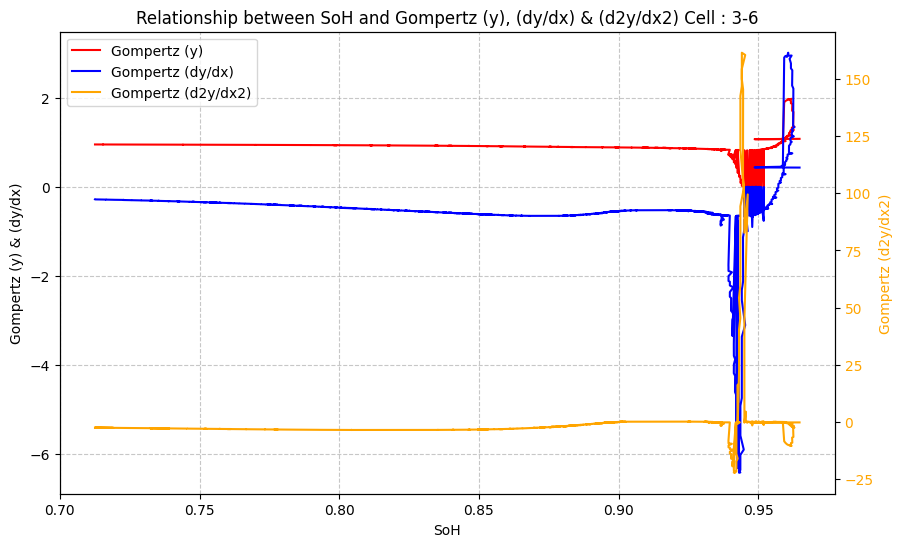

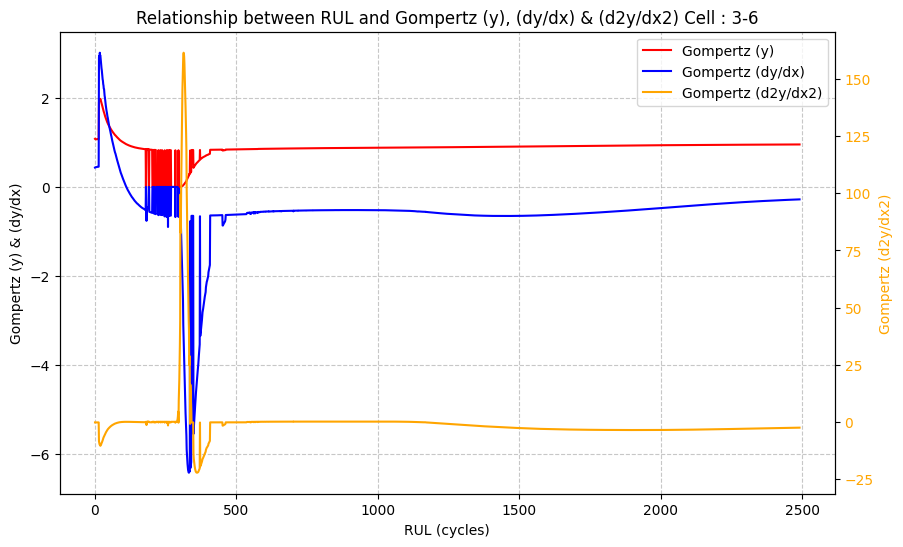

9-8 2308


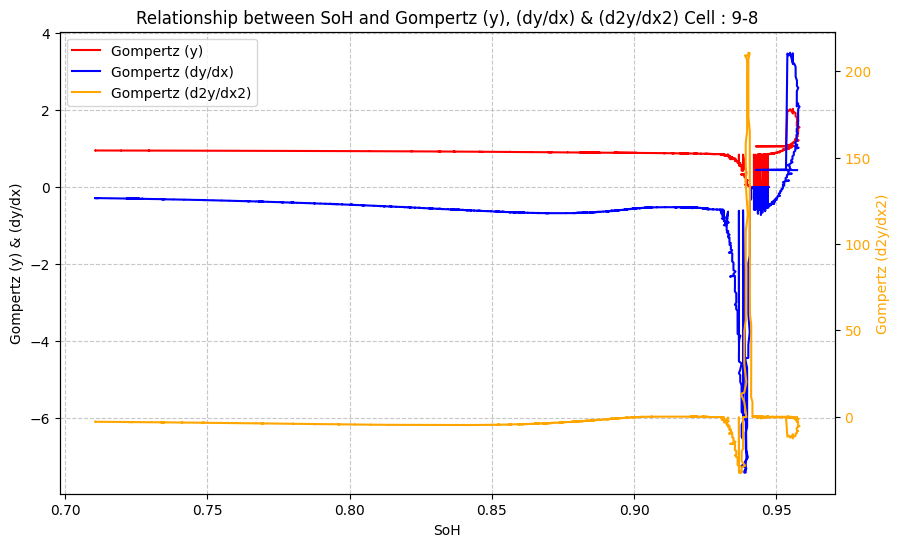

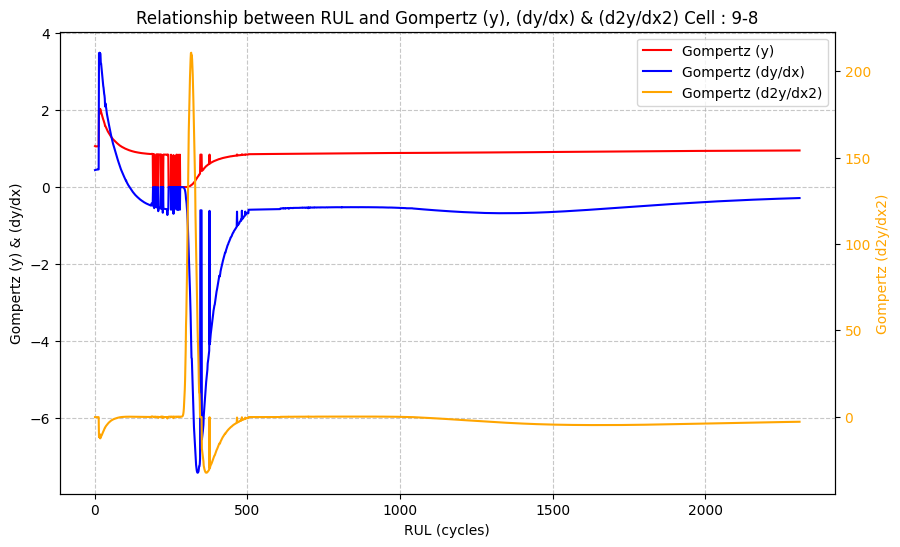

8-2 2041


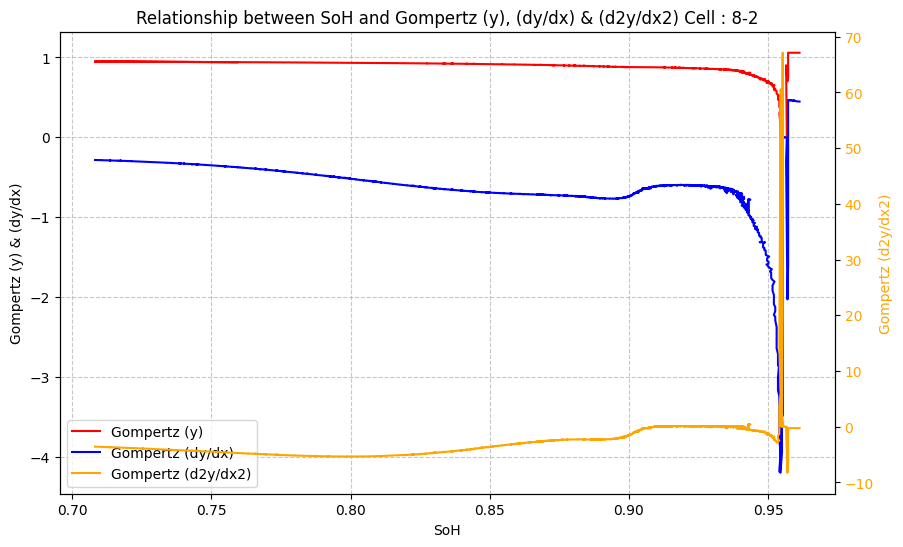

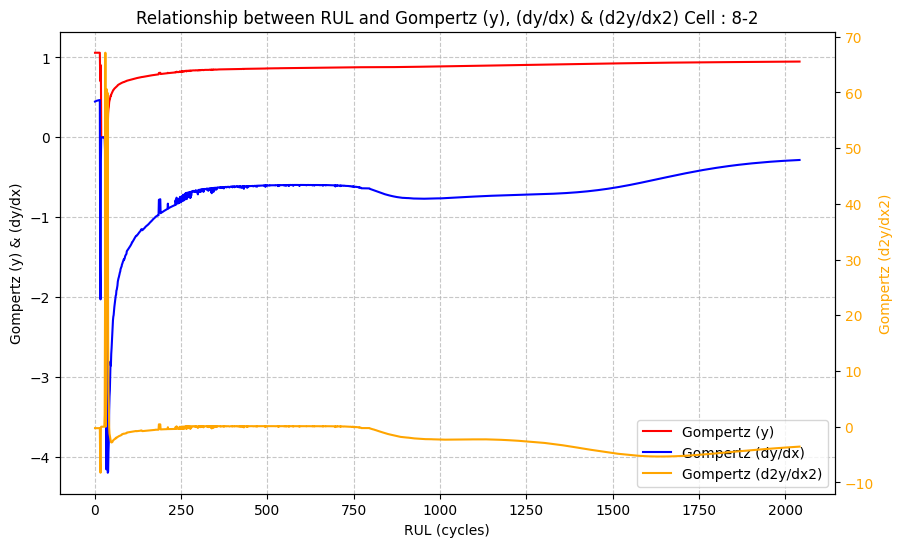

2-2 2651


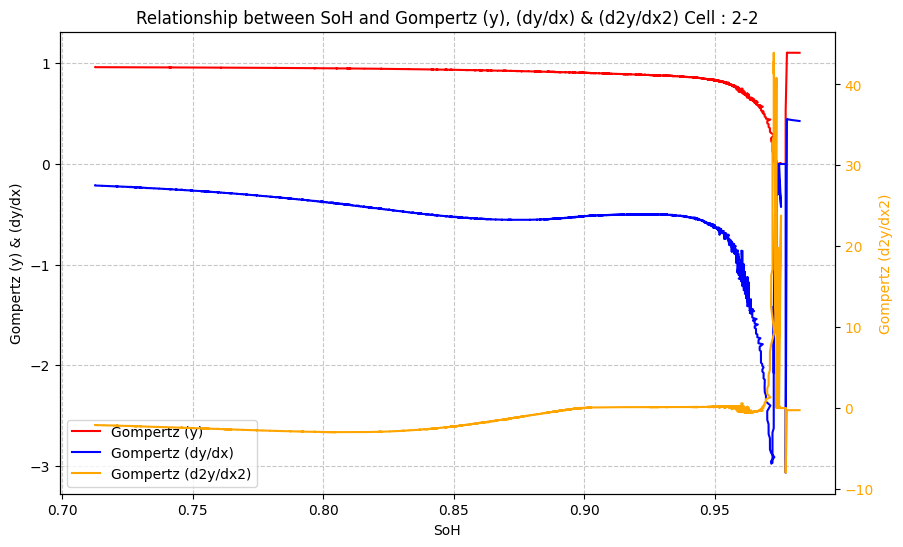

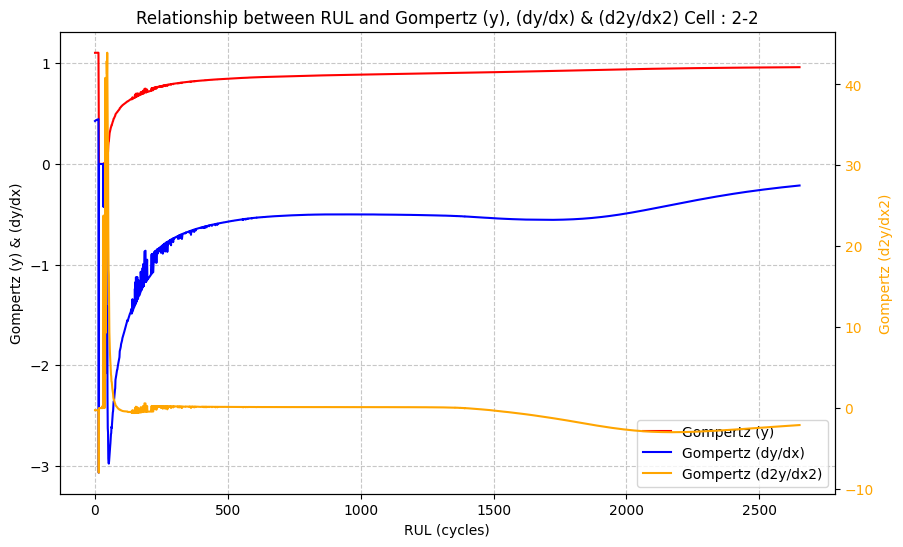

In [51]:
os.makedirs('Parameter-Function-Plots/',exist_ok=True)
tRULs, tSoHs, tGompertz_y,tGompertz_dy_dx,tGompertz_d2y_dx2 = [],[], [], [], [] #list of lists
cRULs, cSoHs, cGompertz_y,cGompertz_dy_dx, cGompertz_d2y_dx2 = [],[], [], [], [] #combine single list   
for k in cycle_lengths_sort.keys():
    print(k,cycle_lengths_sort[k])
    if k == '1-8':
        continue #skip cell 1-8 as it has errors found my experiments and in reproducible experiments as per batteryml#
    RULs, SoHs, Gompertz_y,Gompertz_dy_dx, Gompertz_d2y_dx2 = [],[], [], [], []
    for i in range(1,cycle_lengths_sort[k]+1,1):

        row = unified_gompertz[str(i)][unified_gompertz[str(i)]['cell_name'] == k].squeeze()
        # print('SoH : ',row['SoH'],'Gompertz value',row['gompertz-value'])
        RULs.append(row['Cycle number']), SoHs.append((row['SoH'])),Gompertz_y.append(row['gompertz-value']),Gompertz_dy_dx.append(row['gompertz-1st-derivative-value']),Gompertz_d2y_dx2.append(row['gompertz-2nd-derivative-value'])
        cRULs.append(row['Cycle number']), cSoHs.append((row['SoH'])),cGompertz_y.append(row['gompertz-value']),cGompertz_dy_dx.append(row['gompertz-1st-derivative-value']),cGompertz_d2y_dx2.append(row['gompertz-2nd-derivative-value'])
    #Reverse SoHs and Gomperz so that plots are in reducing RUL order
    # RULs = RULs[::-1]
    # SoHs = SoHs[::-1]
    # Gompertz_y = Gompertz_y[::-1]
    # Gompertz_dy_dx = Gompertz_dy_dx[::-1]
    tRULs.append(RULs), tSoHs.append(SoHs),tGompertz_y.append(Gompertz_y),tGompertz_dy_dx.append(Gompertz_dy_dx),tGompertz_d2y_dx2.append(Gompertz_d2y_dx2)
    
    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    # Plot Gompertz_y and Gompertz_dy_dx on the primary axis (ax1)
    # Storing the line objects to create a combined legend later
    l1, = ax1.plot(SoHs, Gompertz_y, color='red', label='Gompertz (y)')
    l2, = ax1.plot(SoHs, Gompertz_dy_dx, linestyle='-', color='blue', label='Gompertz (dy/dx)')
    
    # Configure the primary axis
    ax1.set_xlabel('SoH')
    ax1.set_ylabel('Gompertz (y) & (dy/dx)') # Label for left axis
    #ax1.set_yscale('log')
    ax1.grid(True, linestyle='--', alpha=0.7)
    
    # Create the secondary axis (right side) sharing the same x-axis
    ax2 = ax1.twinx()
    
    # Plot Gompertz_d2y_dx2 on the secondary axis (ax2)
    l3, = ax2.plot(SoHs, Gompertz_d2y_dx2, color='orange', label='Gompertz (d2y/dx2)')
    
    # Configure the secondary axis
    ax2.set_ylabel('Gompertz (d2y/dx2)', color='orange') # Label for right axis
    ax2.tick_params(axis='y', labelcolor='orange')       # Color the ticks to match
    #ax2.set_yscale('log')
    
    # Combine legends from both axes
    lines = [l1, l2, l3]
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='best') 
    
    # Title and Save
    plt.title(f'Relationship between SoH and Gompertz (y), (dy/dx) & (d2y/dx2) Cell : {k}')
    plt.savefig(f'Parameter-Function-Plots/cell-name-{k}-Cycle-y-dy-dx-d2y-dx2-1.png')
    plt.show()



    
    # Create the figure and the primary axis (left side)
    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    # Plot Gompertz_y and Gompertz_dy_dx on the primary axis (ax1)
    # Storing the line objects to create a combined legend later
    l1, = ax1.plot(RULs, Gompertz_y, color='red', label='Gompertz (y)')
    l2, = ax1.plot(RULs, Gompertz_dy_dx, linestyle='-', color='blue', label='Gompertz (dy/dx)')
    
    # Configure the primary axis
    ax1.set_xlabel('RUL (cycles)')
    ax1.set_ylabel('Gompertz (y) & (dy/dx)') # Label for left axis
    #ax1.set_yscale('log')
    ax1.grid(True, linestyle='--', alpha=0.7)
    
    # Create the secondary axis (right side) sharing the same x-axis
    ax2 = ax1.twinx()
    
    # Plot Gompertz_d2y_dx2 on the secondary axis (ax2)
    l3, = ax2.plot(RULs, Gompertz_d2y_dx2, color='orange', label='Gompertz (d2y/dx2)')
    
    # Configure the secondary axis
    ax2.set_ylabel('Gompertz (d2y/dx2)', color='orange') # Label for right axis
    ax2.tick_params(axis='y', labelcolor='orange')       # Color the ticks to match
    #ax2.set_yscale('log')
    
    # Combine legends from both axes
    lines = [l1, l2, l3]
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='best') 
    
    # Title and Save
    plt.title(f'Relationship between RUL and Gompertz (y), (dy/dx) & (d2y/dx2) Cell : {k}')
    plt.savefig(f'Parameter-Function-Plots/cell-name-{k}-Cycle-y-dy-dx-d2y-dx2-2.png')
    plt.show()
        #break
    #break

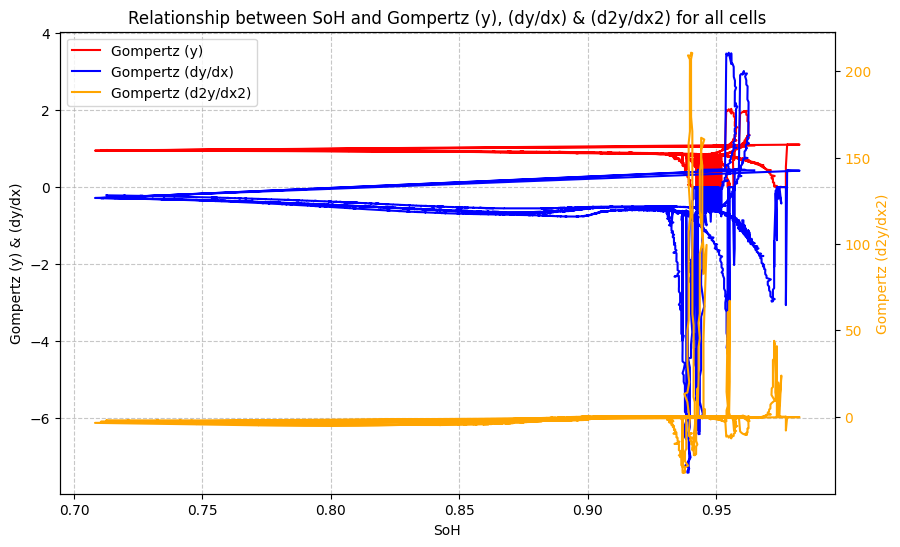

In [52]:
# Create the figure and the primary axis (left side)
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Gompertz_y and Gompertz_dy_dx on the primary axis (ax1)
# Storing the line objects to create a combined legend later
l1, = ax1.plot(cSoHs, cGompertz_y, color='red', label='Gompertz (y)')
l2, = ax1.plot(cSoHs, cGompertz_dy_dx, linestyle='-', color='blue', label='Gompertz (dy/dx)')

# Configure the primary axis
ax1.set_xlabel('SoH')
ax1.set_ylabel('Gompertz (y) & (dy/dx)') # Label for left axis
#ax1.set_yscale('log')
ax1.grid(True, linestyle='--', alpha=0.7)

# Create the secondary axis (right side) sharing the same x-axis
ax2 = ax1.twinx()

# Plot Gompertz_d2y_dx2 on the secondary axis (ax2)
l3, = ax2.plot(cSoHs, cGompertz_d2y_dx2, color='orange', label='Gompertz (d2y/dx2)')

# Configure the secondary axis
ax2.set_ylabel('Gompertz (d2y/dx2)', color='orange') # Label for right axis
ax2.tick_params(axis='y', labelcolor='orange')       # Color the ticks to match
#ax2.set_yscale('log')

# Combine legends from both axes
lines = [l1, l2, l3]
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='best') 

# Title and Save
plt.title(f'Relationship between SoH and Gompertz (y), (dy/dx) & (d2y/dx2) for all cells')
plt.savefig(f'combined-SoH-y-dy-dx.png')
plt.show()

In [53]:
cell_mins, cell_maxs = [], []
for cell in tSoHs:
    cell_min = (min(cell))
    cell_max = (max(cell))
    cell_mins.append(cell_min)
    cell_maxs.append(cell_max)
    #print(cell_min)
print('Local lowest cut off : ',min(cell_mins),' \nGlobal lowest cut off ',max(cell_mins))
print('Local highest cut off : ',min(cell_maxs),' \nGlobal highest cut off ',max(cell_maxs))

Local lowest cut off :  0.708194273166447  
Global lowest cut off  0.7126139284145822
Local highest cut off :  0.958209110671936  
Global highest cut off  0.9824482696530537


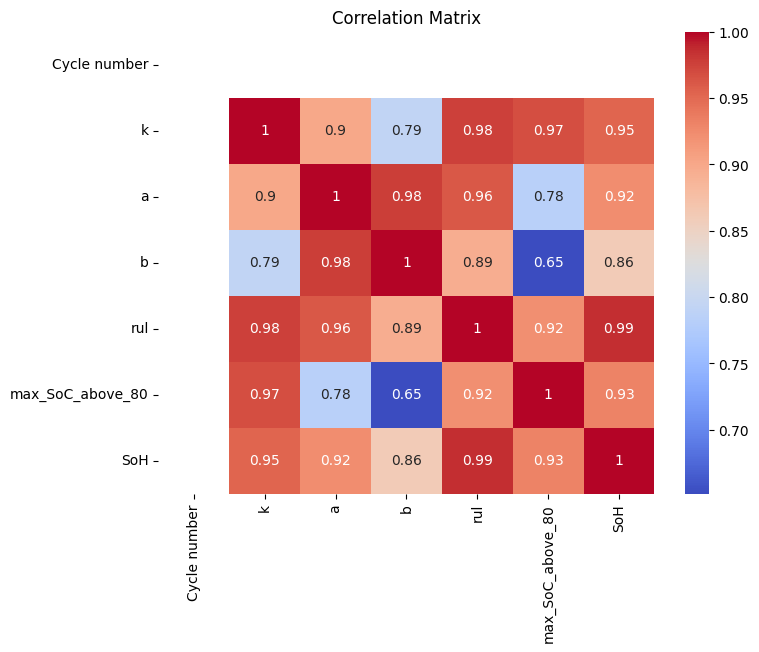

In [54]:
corr = unified_gompertz['1000'][['Cycle number','k','a','b','rul','max_SoC_above_80','SoH']].corr()#df.corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

In [55]:
temp_data = gompertz_df_full[gompertz_df_full["Cycle number"]==1].iloc[0].to_dict()
temp_data

{'Cycle number': 1,
 'k': 1.6257642279791686,
 'a': -0.6857054938936346,
 'b': 1.0001685530883844,
 'rul': 2651,
 'max_SoC_above_80': 31.89879883838364,
 'SoH': 0.9824482696530537,
 'gompertz-value': 1.104690974345624,
 'gompertz-1st-derivative-value': 0.4269382013261776,
 'gompertz-2nd-derivative-value': -0.2620081561964048,
 'cell_name': '2-2'}

In [56]:
values = sorted(cycle_lengths)
import numpy as np
bins = np.linspace(min(values), max(values), 12)
digitized = np.digitize(values, bins)

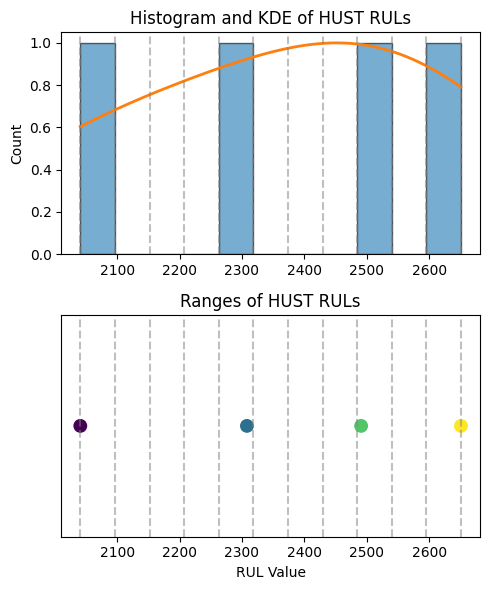

In [57]:
from scipy.stats import gaussian_kde


k = 77

# KDE estimator
kde = gaussian_kde(values)

# Smooth x-grid for KDE
x_grid = np.linspace(min(values), max(values), 500)
kde_vals = kde(x_grid)

# Compute histogram counts WITHOUT density=True
hist_counts, hist_bins = np.histogram(values, bins=bins)

# Scale KDE to match histogram peak
kde_scaled = kde_vals * max(hist_counts) / max(kde_vals)

# --- Plot ---
fig, axes = plt.subplots(2, 1, figsize=(5, 6), sharex=False)

# 1️⃣ Histogram (counts) + scaled KDE
axes[0].hist(values, bins=bins, edgecolor="black", alpha=0.6)   # counts mode

# Plot scaled KDE
axes[0].plot(x_grid, kde_scaled, linewidth=2)

axes[0].set_title("Histogram and KDE of HUST RULs")
axes[0].set_ylabel("Count")

# Bin edges
for b in bins:
    axes[0].axvline(b, color='gray', linestyle='--', alpha=0.5)

# 2️⃣ Scatter plot with bin edges
axes[1].scatter(values, np.zeros_like(values), c=digitized, s=80)
for b in bins:
    axes[1].axvline(b, color='gray', linestyle='--', alpha=0.5)

axes[1].set_yticks([])
axes[1].set_title("Ranges of HUST RULs")
axes[1].set_xlabel("RUL Value")

plt.tight_layout()
plt.show()

In [58]:
def plot_battery_fade(x, y, choice):
    """
    Plots battery capacity fade with intersection points labeled next to the markers.
    
    Args:
        x (array-like): Cycle numbers.
        y (array-like): State of Health (SoH) or Capacity values.
        choice (str/int): Identifier for the battery (e.g., cell ID).
    """
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.plot(x, y, label=f"Bat {choice}", color='b') # Uncomment if you want the main line
    
    ax.set_xlabel('Cycle number')
    ax.set_ylabel('SoH')
    ax.set_title(f'HUST Battery {choice} Capacity Fade')
    
    # --- FIX START: Force plot to start at 0,0 ---
    ax.set_xlim(left=0)   # X-axis starts at 0
    ax.set_ylim(bottom=70) # Y-axis starts at 0
    # ---------------------------------------------
    
    x_hits = []
    y_hits = []
    
    # Horizontal reference lines
    for val in range(72, 93+3+1, 3):
        # ax.axhline(y=val, color='r', linestyle='--', linewidth=0.8)
        
        # Find intersection
        # Check if 'y' exists before this; assuming it's defined elsewhere
        idx = np.where(np.diff(np.sign(y - val)))[0]
        if len(idx) > 0:
            i = idx[0]
            x_int = x[i] + (x[i+1] - x[i]) * (val - y[i]) / (y[i+1] - y[i])
            
            # Save intersection
            x_hits.append(x_int)
            y_hits.append(val)
            
    #         # Draw vertical line and label
    #         # ax.axvline(x=x_int, color='k', linestyle='-', linewidth=0.8)
    #         ax.text(x_int, 107, f"{int(x_int)}", rotation=45,
    #                 va='bottom', ha='center', fontsize=7, color='k')
    
    # # --- Plot intersection points ---
    # ax.scatter(x_hits, y_hits, color='k', s=20, zorder=5, label='Intersections')
    # --- PLOT TEXT NEARBY ---
            # Instead of 107, we use 'val + 0.5' to place it just above the point
            ax.text(x_int, val + 0.4, f"{int(x_int)}", 
                    rotation=0,         # No rotation needed if close to point
                    va='center',        # Anchor bottom of text to the point
                    ha='left',        # Center horizontally
                    fontsize=8, 
                    color='black',
                    fontweight='bold')
    
    # --- Plot all intersection points at once ---
    if x_hits:
        ax.scatter(x_hits, y_hits, color='k', s=20, zorder=5, label='Intersections')
    
    plt.legend()
    plt.tight_layout()
    plt.show()

In [138]:
# Define the function
def gompertz_func(x,k,a,b):
    return k*np.exp(-np.exp(a-(b*x)))

def inverse_gompertz_func(y,k,a,b):
    return (a - np.log(np.log(k/y)))/b

def plot_inverse_mapping_strategy(df,df_target,current_soh,k,a,b,SoH_threshold=None,choice=None,cycle_nums=[]):
    x = np.array([j/10000 for j in range(1,3000,1)]) #df['Cycle number'].to_numpy()/10000
    # Compute y values
    y = gompertz_func(x,k,a,b)
    print("70% SoH RUL estimation: ",int(inverse_gompertz_func(y=0.7,k=k,a=a,b=b)*10000))
    # Plot the function
    plt.figure(figsize=(8, 5))
    
    # plt.plot(df['Cycle number']/len(df['Cycle number']), ((df['max_SOC']-80)/(df['max_SOC'].max()-80)), label="Bat 2-2")
    # plt.plot(x[:len(df['SoH'])], ((df['SoH']-80)/(115-80)), label=choice,color='b')
    plt.plot(x[:len(df['SoH'])], df['SoH'], label=f'{choice} - available SoH curve',color='b',linestyle='-', linewidth=2)
    plt.plot(x[:len(df_target['SoH'])], df_target['SoH'], label=f'{choice} - target SoH curve',color='green',linestyle='dotted', linewidth=2)
    plt.plot(x, y, label=r'Gompertz function', color='r',linestyle='-', linewidth=1)
    # plt.axhline(0, color='black', linewidth=0.5)
    # plt.axhline(1, color='black', linewidth=0.5)
    # plt.axvline(0, color='black', linewidth=0.5)
    plt.xlabel("normalized Cycle Number (x)")
    plt.ylim(0.6, 1)
    plt.xlim(0, 0.3)
    plt.ylabel("SoH")
    plt.title(f"Prediction at {current_soh} SoH", fontsize=12, fontweight='bold')
    #f"Plot of gompertz function k = {round(k,2)}, a = {round(a,2)} and b = {round(b,2)}")
    plt.grid(not True)
    plt.axhline(y=0.7, color='black', label=f'Failure Threshold (0.7 SoH)')
    plt.axvline(x=len(df['SoH'])/10000, color='grey', label='Current Cycle')
    if current_soh == '93%':
        plt.legend()
    # Show the plot
    plt.show()

# FIX CELL BELOW

In [139]:
def obtain_SoH_thresholds_and_cycle_nums(df):
    '''
    Given a dataframe with SoH values as well as Cycle numbers, this function should return
    the cycles needed to reach following SoH thresholds 'BoL','96%','93%','90%','87%','84%','81%','78%','75%','72%','EoL'/'70%'
    '''

    df['SoH'] = ((df['SoH'])*100)

    BoL_SoH, EoL_SoH = 1, len(df['SoH'])
    
    # x = df['Cycle number'].to_numpy()
    # y = df['SoH'].to_numpy()
    
    # # Horizontal reference lines
    # for val in range(72, 93+3+1, 3):
    #     # --- Find intersection ---
    #     # Compute where SoH crosses the horizontal line
    #     idx = np.where(np.diff(np.sign(y - val)))[0]
    #     if len(idx) > 0:
    #         # Take first intersection (or loop for all)
    #         i = idx[0]
    #         # Linear interpolation between points
    #         x_int = x[i] + (x[i+1] - x[i]) * (val - y[i]) / (y[i+1] - y[i])
            
    #         # Draw vertical line
    #         #ax.axvline(x=x_int, color='k', linestyle='-', linewidth=0.4)
    #         # Add label
    #         #ax.text(x_int, 79, f"{int(x_int)}", rotation=90,
    #         #        va='bottom', ha='center', fontsize=7, color='k')
    
    x = df['Cycle number'].to_numpy()
    y = df['SoH'].to_numpy()
    
    
    x_hits = []
    y_hits = []
    
    # Horizontal reference lines
    for val in range(72, 93+3+1, 3):
        
        # Find intersection
        idx = np.where(np.diff(np.sign(y - val)))[0]
        if len(idx) > 0:
            i = idx[0]
            x_int = x[i] + (x[i+1] - x[i]) * (val - y[i]) / (y[i+1] - y[i])
            
            # Save intersection
            x_hits.append(x_int)
            y_hits.append(val)
    x_values = [int(k) for k in x_hits][::-1]
    df['SoH'] = ((df['SoH'])/100)
    return [BoL_SoH,*x_values,EoL_SoH] #unpack all values

In [143]:
def plot_SoH_curves(df):
    # Create figure with subplots
    fig = plt.figure()
    
    plt.plot(df['Cycle number'], ((df['SoH'])), label=f"Bat {choice}")
    
    plt.xlabel('Cycle number')
    plt.ylabel('SoH')
    plt.title(f'HUST Battery {choice} Capacity Fade')
    
    plt.tight_layout()
    plt.show()

[1, 518, 1041, 1369, 1606, 1797, 1964, 2118, 2263, 2308]
9-8


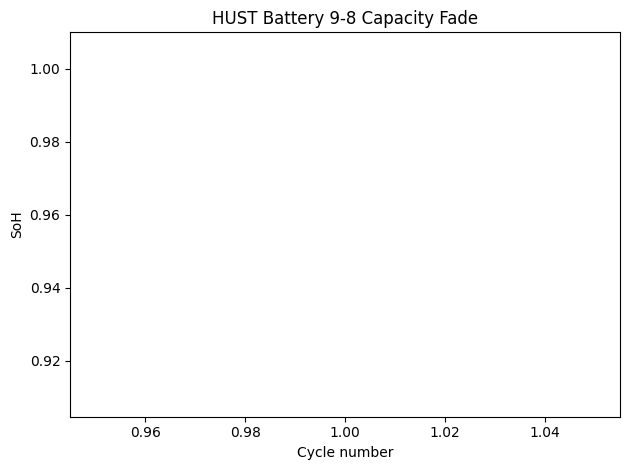

SoH Threshold :  BoL
1.613549872044767 -0.6499110479630144 1.0001649722453554
70% SoH RUL estimation:  -4696


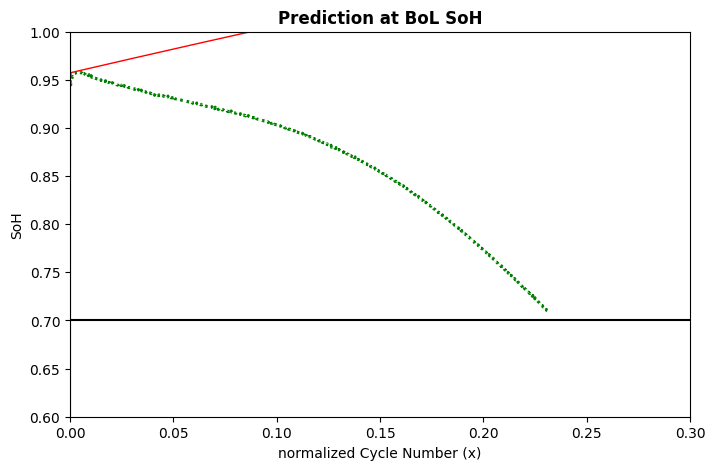

9-8


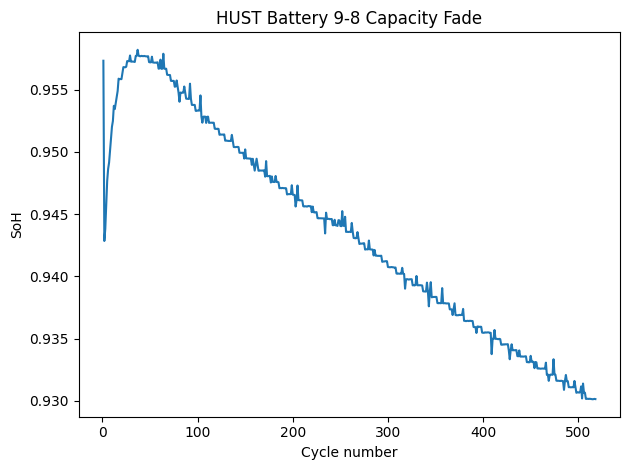

SoH Threshold :  96%
1.6517985986612729 -0.6070678452534444 -1.0418093895934784
70% SoH RUL estimation:  4363


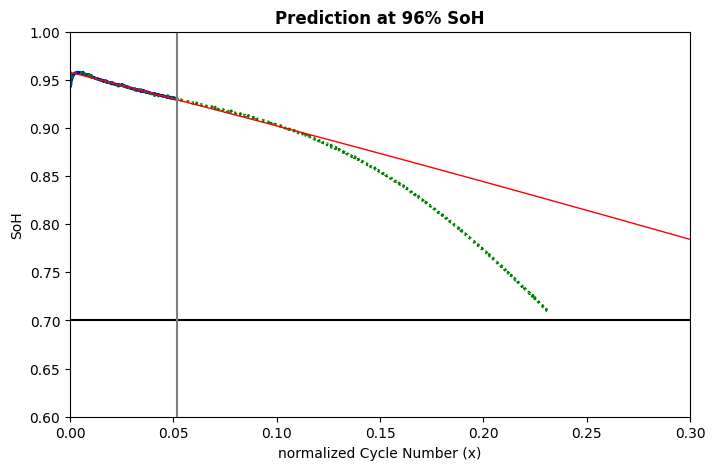

9-8


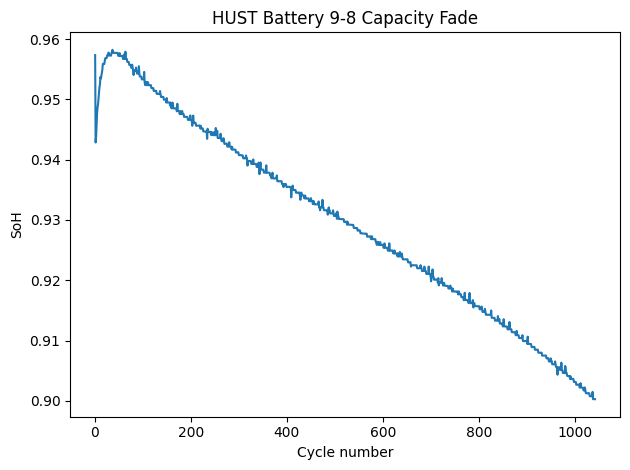

SoH Threshold :  93%
1.591120771616814 -0.6773582535200953 -1.072269609111331
70% SoH RUL estimation:  4478


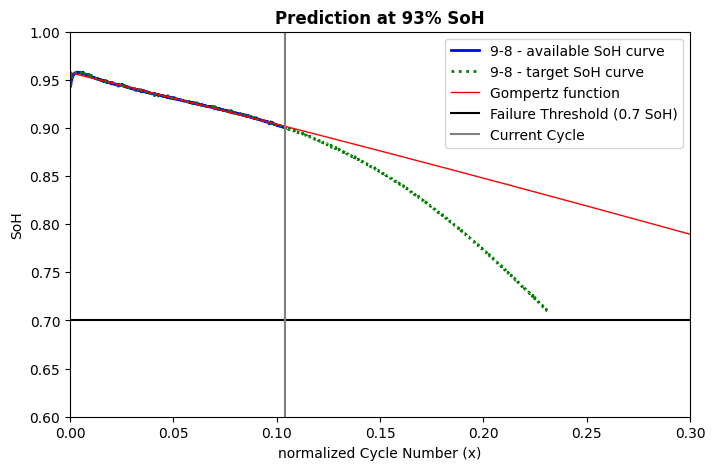

9-8


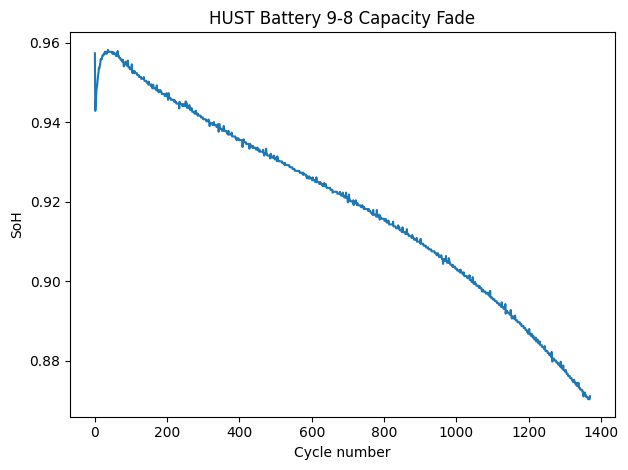

SoH Threshold :  90%
1.0217405384579352 -2.6999918955549225 -6.213535289978092
70% SoH RUL estimation:  2780


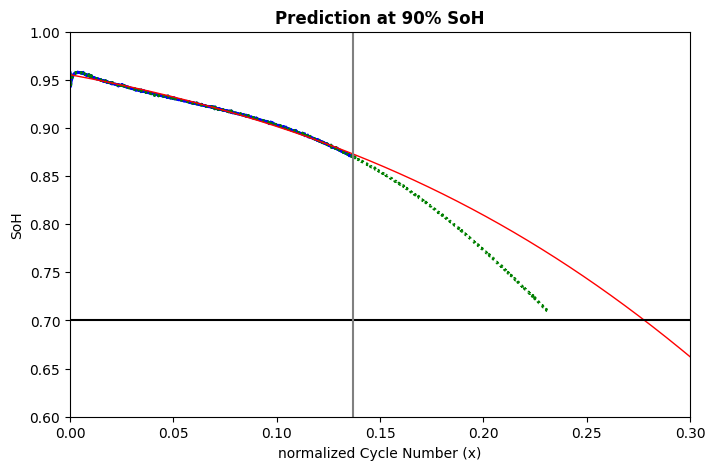

9-8


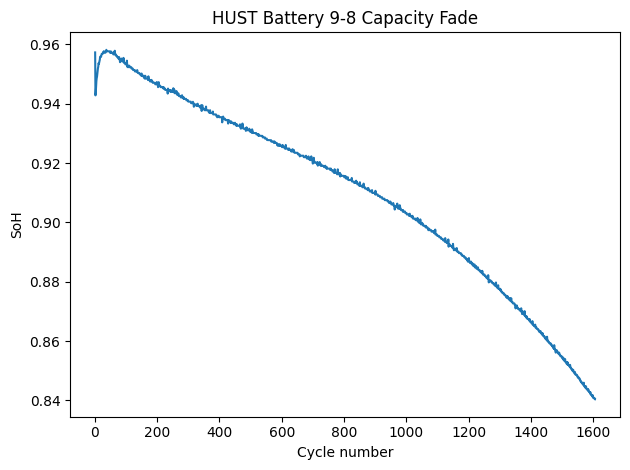

SoH Threshold :  87%
0.992732414108496 -3.2167218519272494 -8.741280777205455
70% SoH RUL estimation:  2476


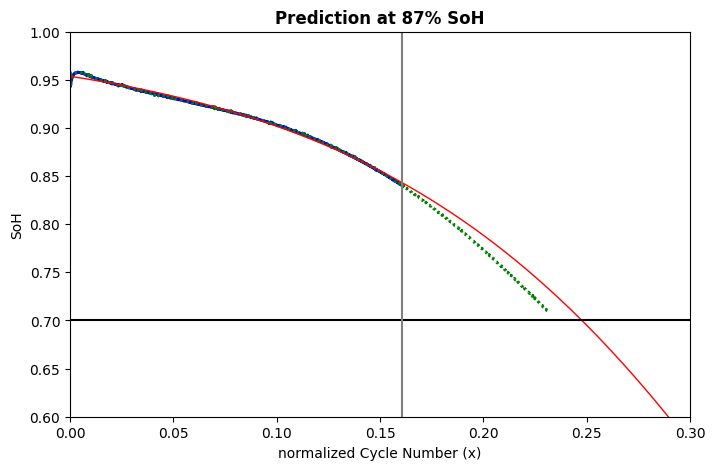

9-8


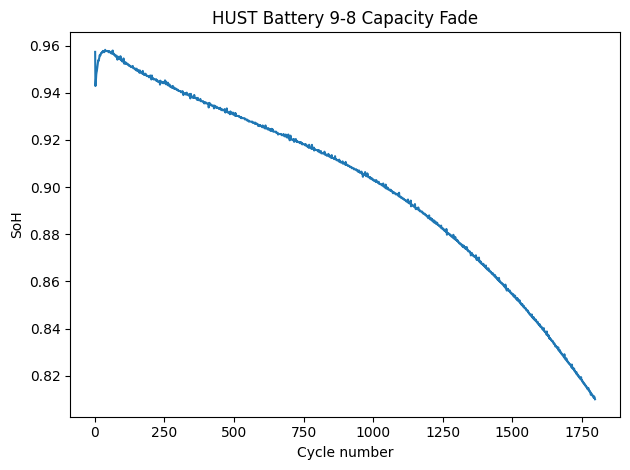

SoH Threshold :  84%
0.9829829927964048 -3.4614491654953032 -10.023220685267304
70% SoH RUL estimation:  2375


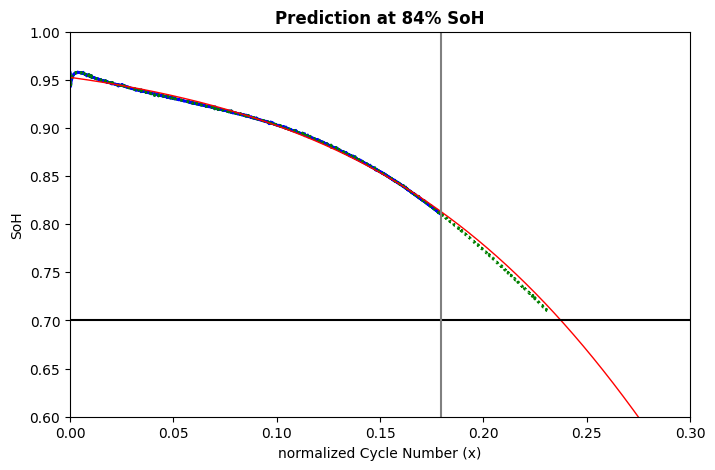

9-8


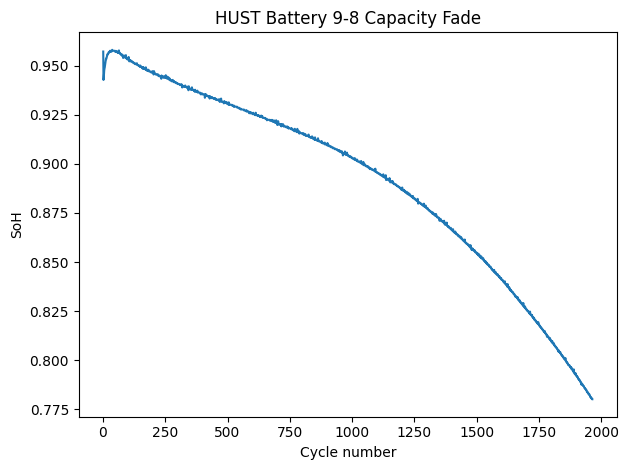

SoH Threshold :  81%
0.9791462903348084 -3.5709442648938405 -10.589743318888866
70% SoH RUL estimation:  2341


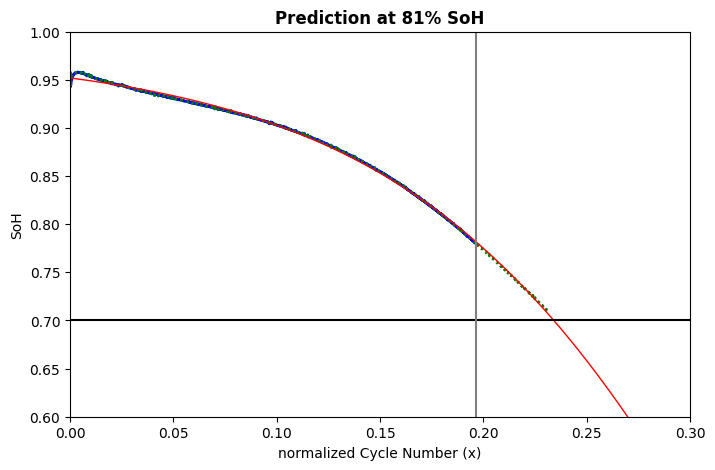

9-8


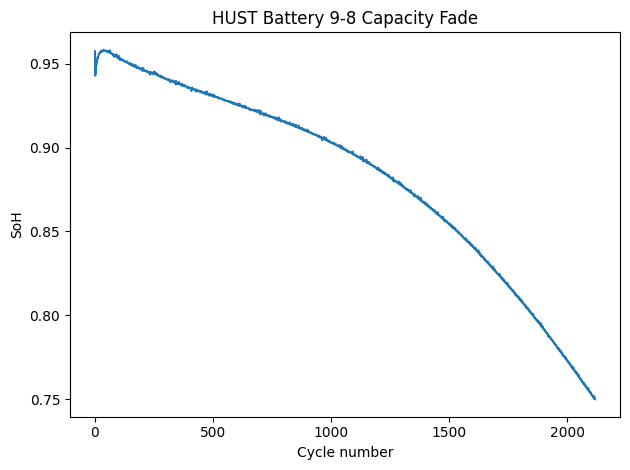

SoH Threshold :  78%
0.9780782415685634 -3.6024196542635414 -10.747676296371823
70% SoH RUL estimation:  2332


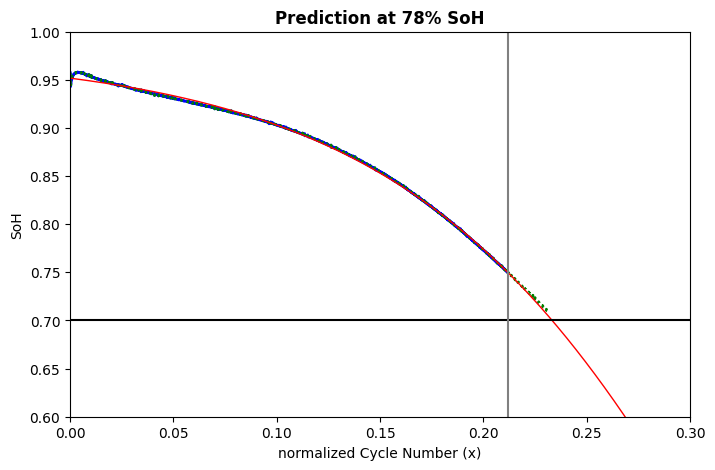

9-8


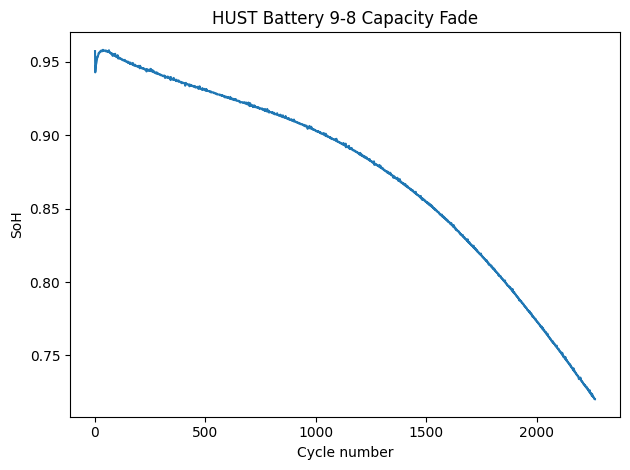

SoH Threshold :  75%
0.978825393499474 -3.581230311222236 -10.647501391134249
70% SoH RUL estimation:  2337


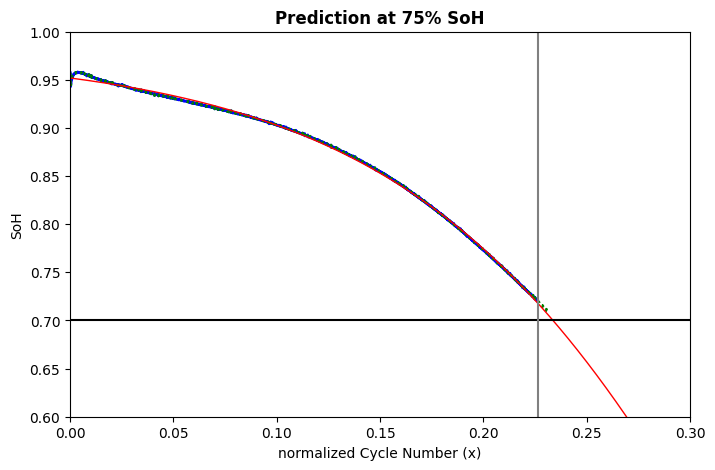

9-8


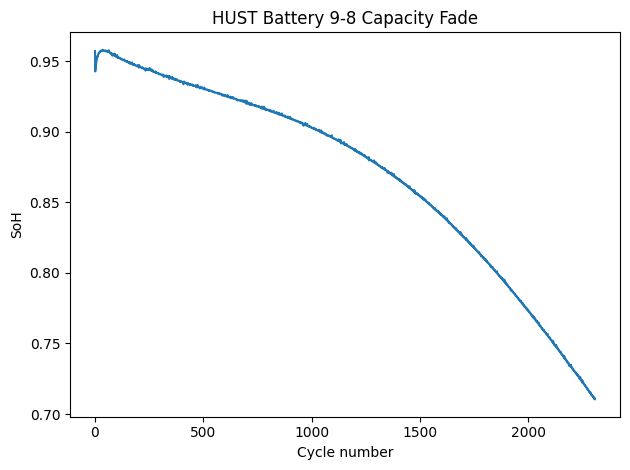

SoH Threshold :  72%
0.9793519535954114 -3.56671912868596 -10.58037943328756
70% SoH RUL estimation:  2339


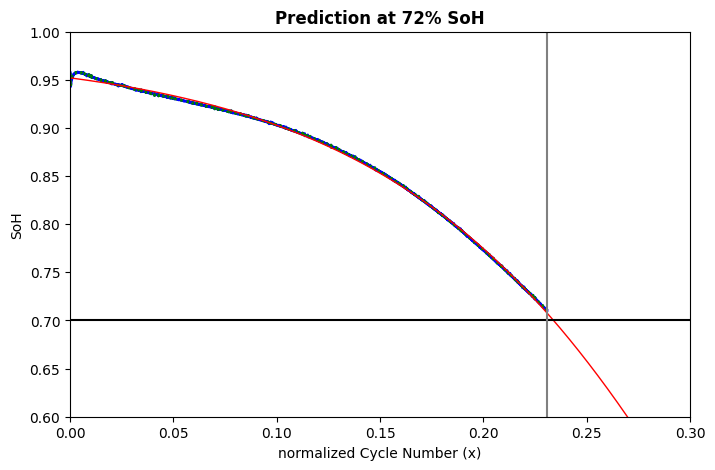

In [144]:
choice = random.choice(pairs)
df = pd.read_csv(base_path + choice + "-hust_gompertz_params.csv")
df['SoH'] = ((df['SoH']))
SoH_Thresholds = ['BoL','96%','93%','90%','87%','84%','81%','78%','75%','72%','70%']
cycle_nums = obtain_SoH_thresholds_and_cycle_nums(df)
print(cycle_nums)
#[1,511,941,1193,1380,1532,1663,1778,1886,1938] #[63,431,637,758,849,925, 992, 1054,1110,1142] #[548,1031,1423,1756,1972,2153,2315,2473,2628,2688]
for i, cycle_num in enumerate(cycle_nums):
    print(choice)
    temp_df = df[df['Cycle number']<=cycle_num]
    plot_SoH_curves(temp_df)
    print('SoH Threshold : ',SoH_Thresholds[i])
    temp_df = df[df['Cycle number']==cycle_num]
    k,a,b = temp_df['k'].item(),temp_df['a'].item(),temp_df['b'].item()
    print(k,a,b)
    #temp_df.head()
    # gompertz_func(x=df,k=k,a=a,b=b)
    plot_inverse_mapping_strategy(df=df.iloc[0:cycle_num],df_target=df,current_soh=SoH_Thresholds[i],k = k,a = a,b = b,choice=choice)

    

In [142]:
# # ... (your existing data loading)

# plt.figure(figsize=(6, 4))

# # 1. Plot Data
# plt.plot(x_train, y_train, 'b-', label='Available Data', linewidth=2)
# plt.plot(x_test, y_test, 'g:', label='Ground Truth', linewidth=2, alpha=0.7)
# plt.plot(x_full, y_pred, 'r-', label='Gompertz Prediction', linewidth=1.5)

# # 2. Add "Present Time" Marker
# cutoff_cycle = x_train[-1]
# plt.axvline(x=cutoff_cycle, color='gray', linestyle='--', alpha=0.5)
# plt.text(cutoff_cycle, 0.72, ' Forecast Start', verticalalignment='bottom', fontsize=9, color='gray')

# # 3. Add Failure Threshold
# plt.axhline(y=0.7, color='black', linestyle='-', linewidth=1.5, label='Failure Threshold')

# # 4. Clean Titles & Labels
# plt.title(f"Prediction at {current_soh}% SoH", fontsize=12, fontweight='bold')
# plt.xlabel("Cycle Number", fontsize=10) # Use integers if possible!
# plt.ylabel("State of Health (SoH)", fontsize=10)
# plt.grid(False)

# # Only show legend if this is the first plot, otherwise hide it
# # plt.legend() 

# plt.tight_layout()
# plt.show()

# 5. Plot trajectories

--------------------------------------------------------------------------------
8-2
2041


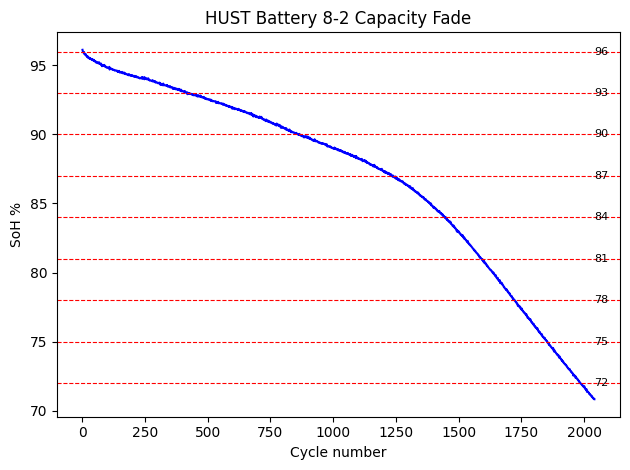

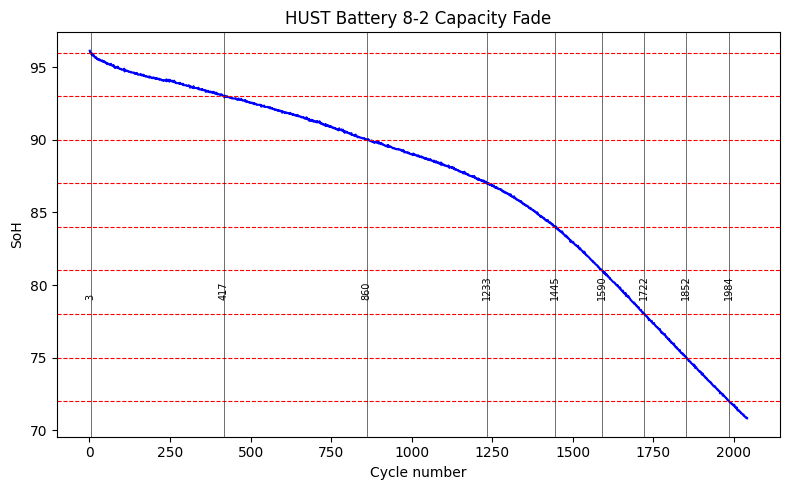

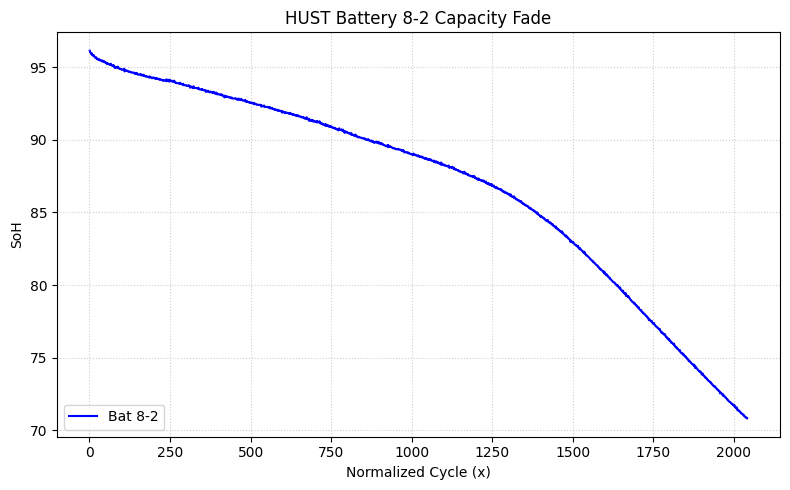

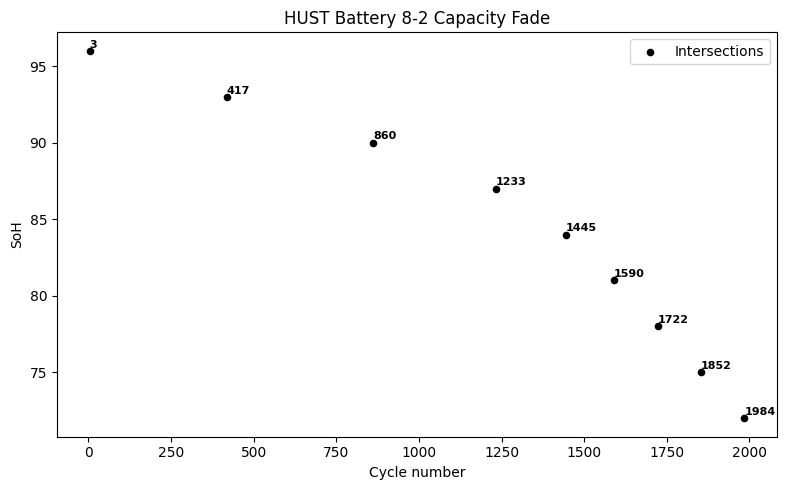

--------------------------------------------------------------------------------
9-8
2308


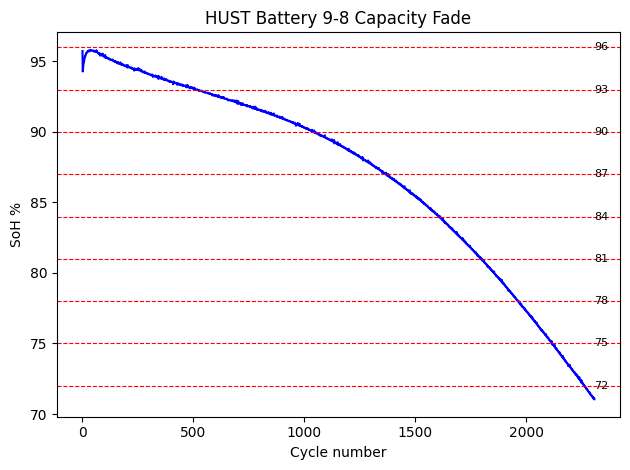

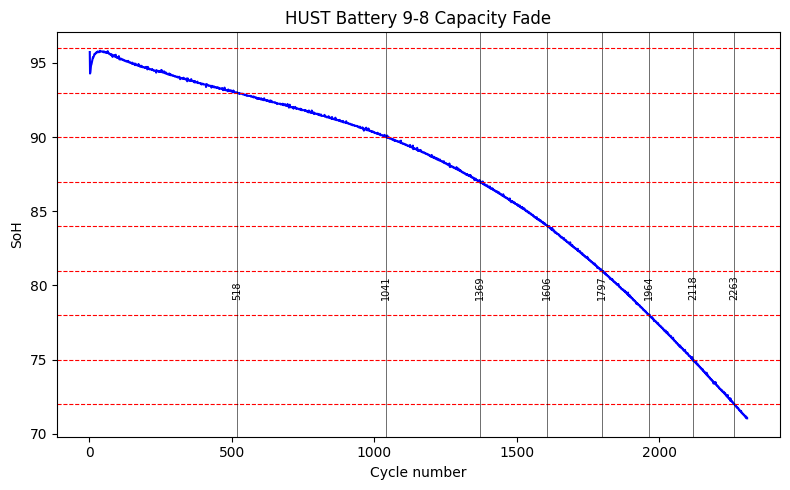

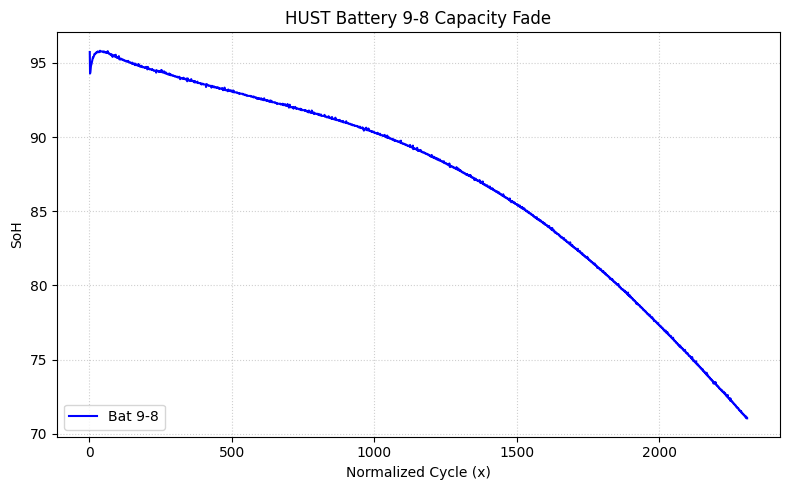

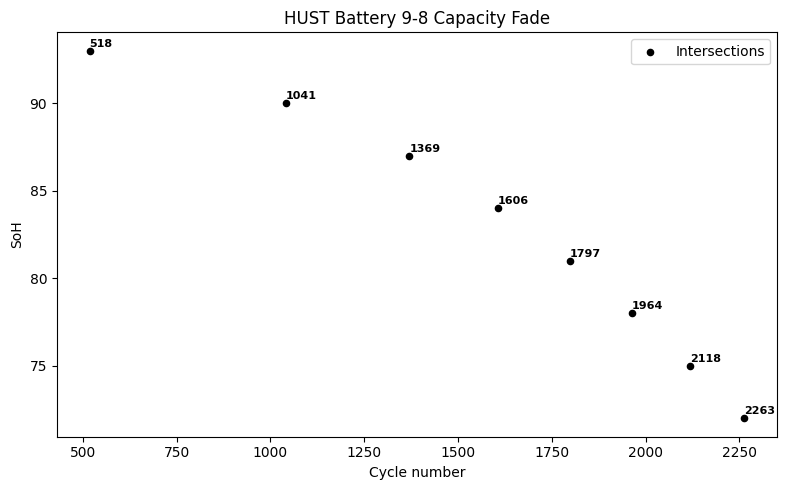

--------------------------------------------------------------------------------
3-6
2491


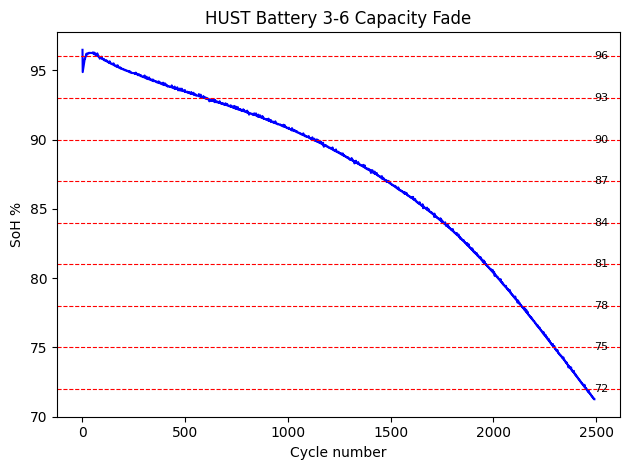

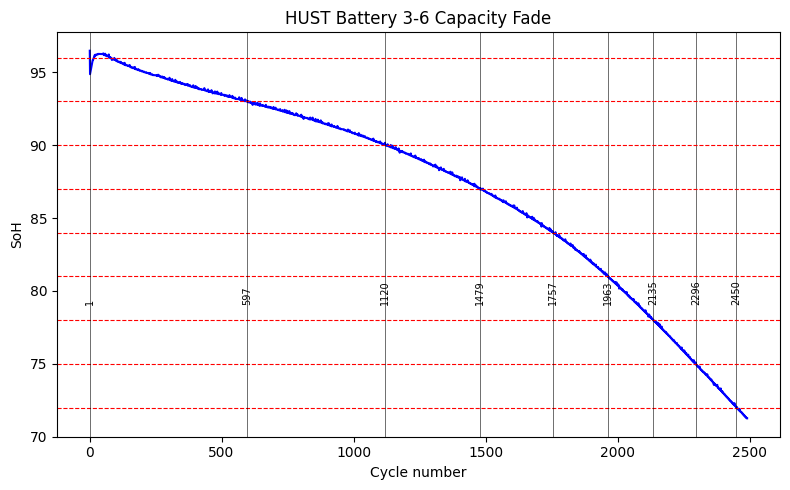

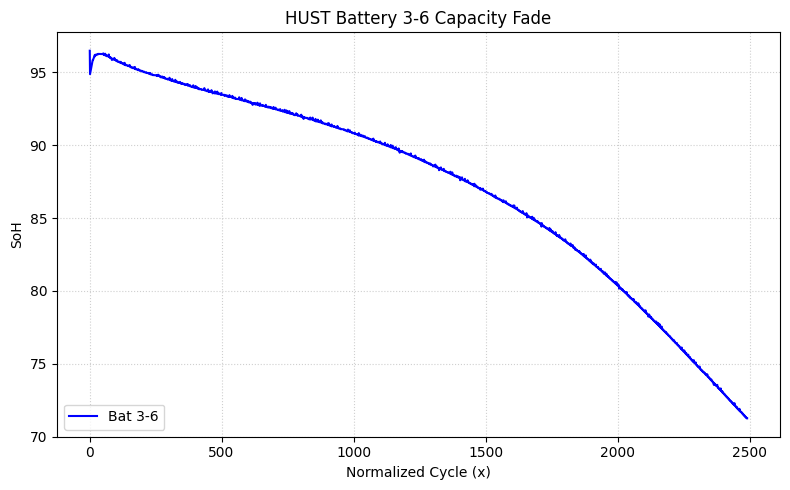

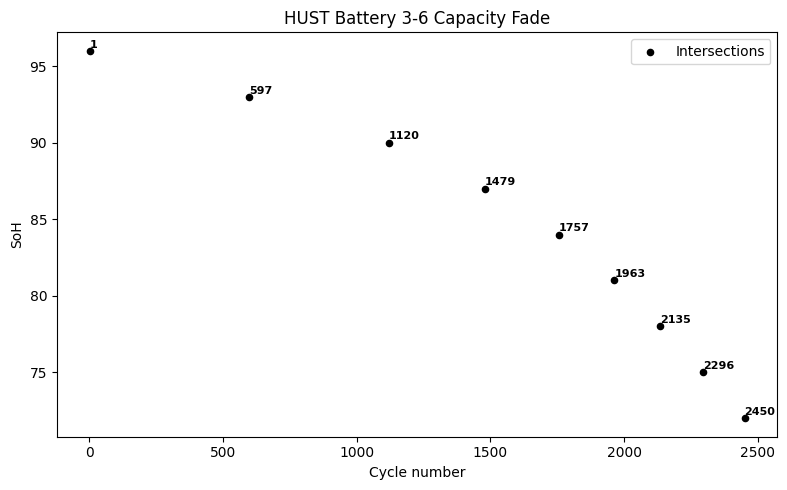

--------------------------------------------------------------------------------
2-2
2651


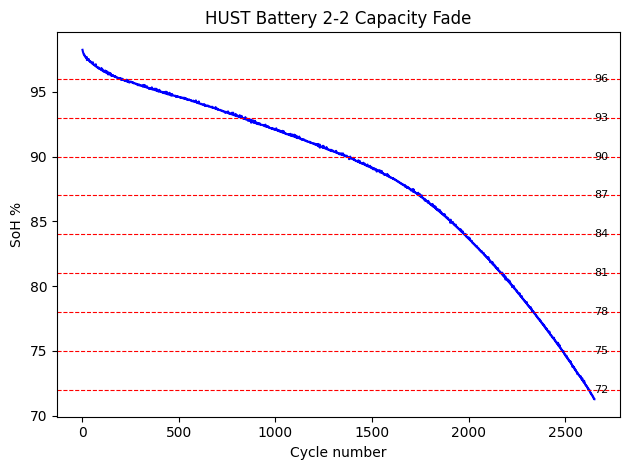

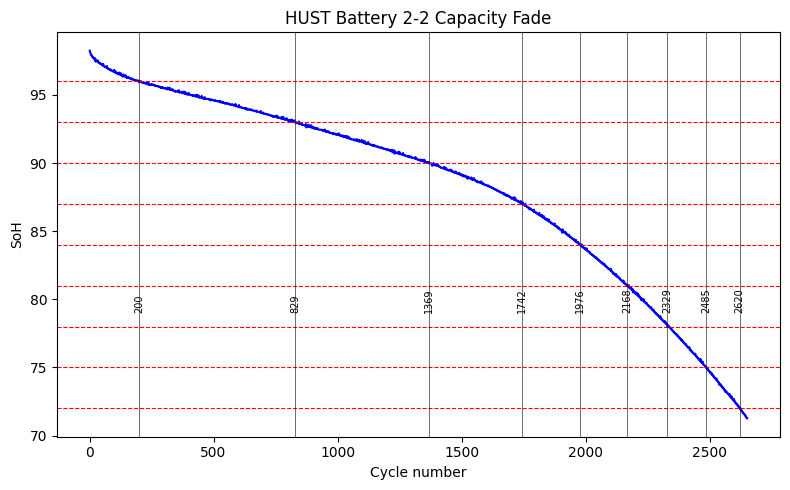

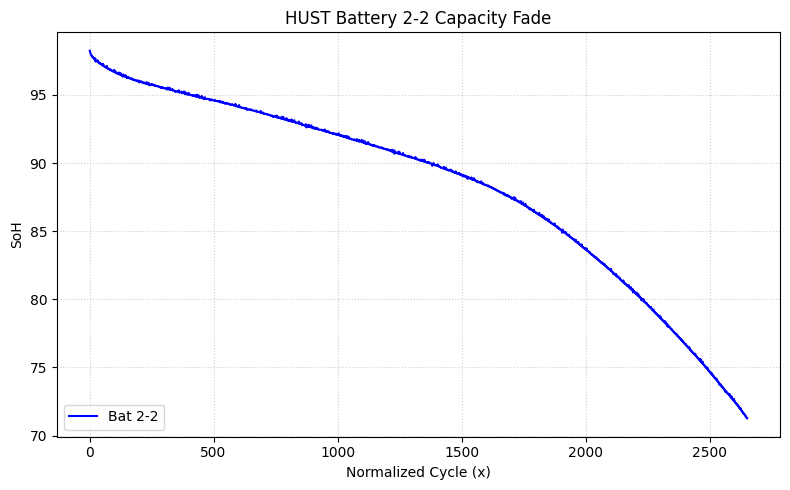

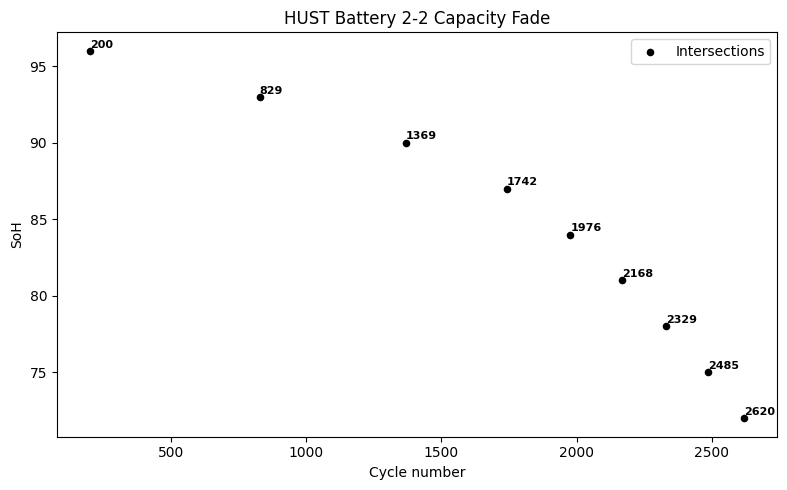

In [137]:
for choice in pairs:
    print('-'*80)
    print(choice)
    df = pd.read_csv(base_path + choice + "-hust_gompertz_params.csv")
    df['SoH'] = ((df['SoH'])*100)
    
    # Create figure
    fig = plt.figure()
    print(len(df['SoH']))
    plt.plot(df['Cycle number'], ((df['SoH']) /1),
             label=f"Bat {choice}", color='b')
    
    plt.xlabel('Cycle number')
    plt.ylabel('SoH %')
    plt.title(f'HUST Battery {choice} Capacity Fade')
    
    # Add horizontal dotted lines
    for val in range(72, 93+3+1, 3):
        #val = round((val-80)/(115-80),4)
        plt.axhline(y=val, color='r', linestyle='--', linewidth=0.8)
        plt.text(df['Cycle number'].max(), val, str(val), va='center', fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    x = df['Cycle number'].to_numpy()
    y = df['SoH'].to_numpy()
    
    # Create figure
    fig, ax = plt.subplots(figsize=(8, 5))
    
    ax.plot(x, y, label=f"Bat {choice}", color='b')
    ax.set_xlabel('Cycle number')
    ax.set_ylabel('SoH')
    ax.set_title(f'HUST Battery {choice} Capacity Fade')
    
    # Horizontal reference lines
    for val in range(72, 93+3+1, 3):
        ax.axhline(y=val, color='r', linestyle='--', linewidth=0.8)
        
        # --- Find intersection ---
        # Compute where SoH crosses the horizontal line
        idx = np.where(np.diff(np.sign(y - val)))[0]
        if len(idx) > 0:
            # Take first intersection (or loop for all)
            i = idx[0]
            # Linear interpolation between points
            x_int = x[i] + (x[i+1] - x[i]) * (val - y[i]) / (y[i+1] - y[i])
            
            # Draw vertical line
            ax.axvline(x=x_int, color='k', linestyle='-', linewidth=0.4)
            # Add label
            ax.text(x_int, 79, f"{int(x_int)}", rotation=90,
                    va='bottom', ha='center', fontsize=7, color='k')
    
    plt.tight_layout()
    plt.show()
    
    x = df['Cycle number'].to_numpy()
    y = df['SoH'].to_numpy()
    plot_battery_fade(x, y, choice)
    # Create figure
    fig, ax = plt.subplots(figsize=(8, 5))
    #ax.plot(x, y, label=f"Bat {choice_csv}", color='b')
    
    ax.set_xlabel('Cycle number')
    ax.set_ylabel('SoH')
    ax.set_title(f'HUST Battery {choice} Capacity Fade')
    
    x_hits = []
    y_hits = []
    
    # Horizontal reference lines
    for val in range(72, 93+3+1, 3):
        #ax.axhline(y=val, color='r', linestyle='--', linewidth=0.8)
        
        # Find intersection
        idx = np.where(np.diff(np.sign(y - val)))[0]
        if len(idx) > 0:
            i = idx[0]
            x_int = x[i] + (x[i+1] - x[i]) * (val - y[i]) / (y[i+1] - y[i])
            
            # Save intersection
            x_hits.append(x_int)
            y_hits.append(val)
            
            # # Draw vertical line and label
            # #ax.axvline(x=x_int, color='k', linestyle='-', linewidth=0.8)
            # ax.text(x_int, 107, f"{int(x_int)}", rotation=45,
            #         va='bottom', ha='center', fontsize=7, color='k')
            ax.text(x_int, val + 0.4, f"{int(x_int)}", 
                    rotation=0,         # No rotation needed if close to point
                    va='center',        # Anchor bottom of text to the point
                    ha='left',        # Center horizontally
                    fontsize=8, 
                    color='black',
                    fontweight='bold')
    
    # --- Plot intersection points ---
    ax.scatter(x_hits, y_hits, color='k', s=20, zorder=5, label='Intersections')
    
    plt.legend()
    plt.tight_layout()
    plt.show()
    #break

In [78]:
def plot_battery_fade(x, y, choice):
    """
    Plots battery capacity fade with intersection points labeled next to the markers.
    Adapted for fractional X (0-1) and Y (0.7-1.0) values.
    """
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.plot(x, y, label=f"Bat {choice}", color='b') 
    
    ax.set_xlabel('Normalized Cycle (x)')
    ax.set_ylabel('SoH')
    ax.set_title(f'HUST Battery {choice} Capacity Fade')
    
    # --- FIX START: Adjust limits for fractional data ---
    #ax.set_xlim(0, 1.0)     # X-axis ranges from 0 to 1
    #ax.set_ylim(0.7, 1.02)  # Y-axis ranges from 0.7 to slightly above 1.0
    # ---------------------------------------------
    
    x_hits = []
    y_hits = []
    
    # --- FIX: Loop for fractions (0.72 to 0.96 with step 0.03) ---
    # We use np.arange. We add a small epsilon (0.001) to the stop value 
    # to ensure the final value (0.96) is included.
    target_values = np.arange(0.72, 0.96 + 0.001, 0.03)

    for val in target_values:
        # Find intersection
        # We calculate the difference between the signal and the target value
        idx = np.where(np.diff(np.sign(y - val)))[0]
        
        if len(idx) > 0:
            i = idx[0]
            # Linear interpolation formula
            x_int = x[i] + (x[i+1] - x[i]) * (val - y[i]) / (y[i+1] - y[i])
            
            # Save intersection
            x_hits.append(x_int)
            y_hits.append(val)
            
            # --- PLOT TEXT NEARBY ---
            # FIX: Adjusted offset. 0.4 is too big for a 0-1 scale. 
            # We use 0.01 to place it slightly above the dot.
            # FIX: Changed f"{int(x_int)}" to f"{x_int:.2f}" because x is < 1.
            ax.text(x_int, val + 0.01, f"{int(x_int*10000)}", 
                    rotation=0, 
                    va='bottom', 
                    ha='left', 
                    fontsize=8, 
                    color='black',
                    fontweight='bold')
    
    # --- Plot all intersection points at once ---
    if x_hits:
        ax.scatter(x_hits, y_hits, color='k', s=20, zorder=5, label='Intersections')
    
    plt.legend(loc='lower left')
    plt.grid(True, linestyle=':', alpha=0.6) # Added grid for better readability on small scales
    plt.tight_layout()
    plt.show()


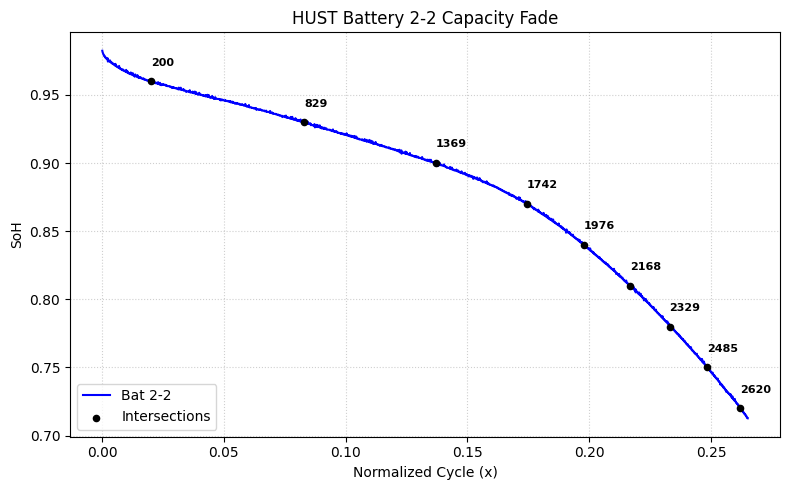

In [65]:
df = pd.read_csv(base_path + choice + "-hust_gompertz_params.csv")
x = df['Cycle number'].to_numpy()/10000
y = df['SoH'].to_numpy()
plot_battery_fade(x, y, choice)

2-2
SoH Threshold :  93%
4.185697829552287 0.3772702078539097 -0.4194558584482366
72% SoH RUL estimation:  4452
90% SoH RUL estimation:  1253
2-2
SoH Threshold :  90%
4.858051107464092 0.4755398374715406 -0.3326353609016831
72% SoH RUL estimation:  5106
90% SoH RUL estimation:  1407
2-2
SoH Threshold :  87%
4.392766365689699 0.4108969653427022 -0.3552328445625565
72% SoH RUL estimation:  5074
90% SoH RUL estimation:  1404
2-2
SoH Threshold :  84%
2.587955721027715 -0.0212595411026459 -0.5465749533485463
72% SoH RUL estimation:  4861
90% SoH RUL estimation:  1389
2-2
SoH Threshold :  81%
1.409623554282608 -0.9892335525064188 -1.3721165238100954
72% SoH RUL estimation:  4284
90% SoH RUL estimation:  1368
2-2
SoH Threshold :  78%
1.1931414481362852 -1.5807893711383378 -2.325617702420501
72% SoH RUL estimation:  3839
90% SoH RUL estimation:  1353
2-2
SoH Threshold :  75%
1.1058487007301967 -2.034673870446684 -3.3848208485550058
72% SoH RUL estimation:  3495
90% SoH RUL estimation:  1343
2-

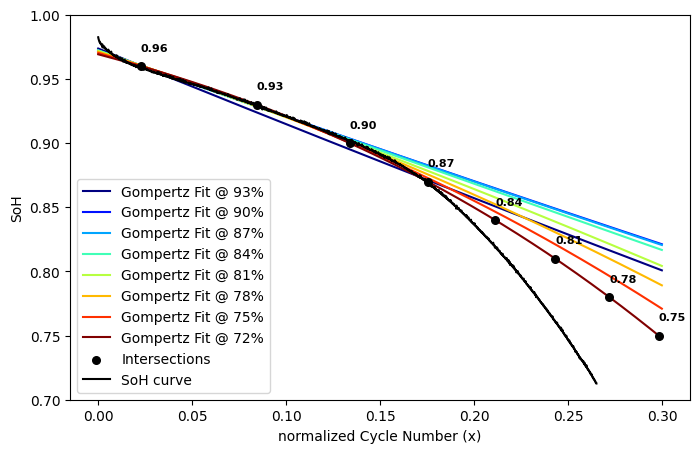

In [66]:
import matplotlib.cm as cm

df = pd.read_csv(base_path + choice + "-hust_gompertz_params.csv")
df['SoH'] = ((df['SoH']))
SoH_Thresholds = ['93%','90%','87%','84%','81%','78%','75%','72%']
cycle_nums = [511,941,1193,1380,1532,1663,1778,1886]#[63,431,637,758,849,925, 992, 1054,1110,1142] #[548,1031,1423,1756,1972,2153,2315,2473,2628,2688]
colors = cm.jet(np.linspace(0, 1, len(cycle_nums)))

def gompertz_func(x,k,a,b):
    return k*np.exp(-np.exp(a-(b*x)))
    
plt.figure(figsize=(8, 5))
for i, cycle_num in enumerate(cycle_nums):
    x = np.array([j/10000 for j in range(1,3000,1)]) 
    print(choice)
    print('SoH Threshold : ',SoH_Thresholds[i])
    temp_df = df[df['Cycle number']==cycle_num]
    k,a,b = temp_df['k'].item(),temp_df['a'].item(),temp_df['b'].item()
    print(k,a,b)
    #temp_df.head()
    # gompertz_func(x=df,k=k,a=a,b=b

    
    print("72% SoH RUL estimation: ",int(inverse_gompertz_func(y=0.72173913,k=k,a=a,b=b)*10000))
    print("90% SoH RUL estimation: ",int(inverse_gompertz_func(y=0.9,k=k,a=a,b=b)*10000))



    # Compute y values
    y = gompertz_func(x,k,a,b)
    

    
    plt.plot(x, y, label=f'Gompertz Fit @ {SoH_Thresholds[i]}', color=colors[i])
    # plt.axhline(0, color='black', linewidth=0.5)
    # plt.axhline(1, color='black', linewidth=0.5)
    # plt.axvline(0, color='black', linewidth=0.5)
    plt.xlabel("normalized Cycle Number (x)")
    plt.ylim(0.7, 1)
    plt.ylabel("SoH")
    # break
x_hits = []
y_hits = []

# Target values: 0.72 to 0.96 with step 0.03
target_values = np.arange(0.72, 0.96 + 0.001, 0.03)

# # Generate distinct colors for each threshold curve
# colors = cm.jet(np.linspace(0, 1, len(target_values)))

for idx_val, val in enumerate(target_values):
    # 1. Find intersection on the main blue line
    # We look for where the data crosses the 'val' threshold
    idx = np.where(np.diff(np.sign(y - val)))[0]
    
    if len(idx) > 0:
        inter = idx[0]
        # Linear interpolation for precise x-coordinate
        x_int = x[inter] + (x[inter+1] - x[inter]) * (val - y[inter]) / (y[inter+1] - y[inter])
        
        x_hits.append(x_int)
        y_hits.append(val)
        
        # 2. Overlay Gompertz Curve (if df_params is provided)
        if df is not None:
            # Find the row in df_params with SoH closest to current 'val'
            # We assume df_params has a column 'SoH' (fractions like 0.93) or similar.
            # If df uses strings '93%', you might need to convert them first.
            
            # Finding closest match by absolute difference
            closest_row_idx = (df['SoH'] - val).abs().idxmin()
            row = df.loc[closest_row_idx]
            
            k, a, b = row['k'], row['a'], row['b']
            
            # Generate the Gompertz curve
            # NOTE: If k, a, b were fitted on INTEGER cycles, we must treat x as such
            # or assume the user has normalized k, a, b.
            # Here, we pass 'x' (0-1) directly. 
            #y_gomp = gompertz_func(x, k, a, b)
            
            # ax.plot(x, y_gomp, 
            #         color=colors[idx_val], 
            #         linestyle='--', 
            #         linewidth=1, 
            #         alpha=0.7,
            #         label=f"Fit @ {val:.2f}" if idx_val % 2 == 0 else "") # Label every other to reduce clutter

        # 3. Label the point
        plt.text(x_int, val + 0.01, f"{val:.2f}", 
                rotation=0, va='bottom', ha='left', fontsize=8, fontweight='bold')

# Plot intersection dots
if x_hits:
    plt.scatter(x_hits, y_hits, color='k', s=30, zorder=5, label='Intersections')

plt.plot(x[:len(df['SoH'])], df['SoH'], label='SoH curve',color='black')
#plt.title(f"Plot of gompertz function k = {round(k,2)}, a = {round(a,2)} and b = {round(b,2)}")
plt.legend()
plt.grid(not True)

# Show the plot
plt.show()

2-2
SoH Threshold :  93%
4.185697829552287 0.3772702078539097 -0.4194558584482366
72% SoH RUL estimation:  4452


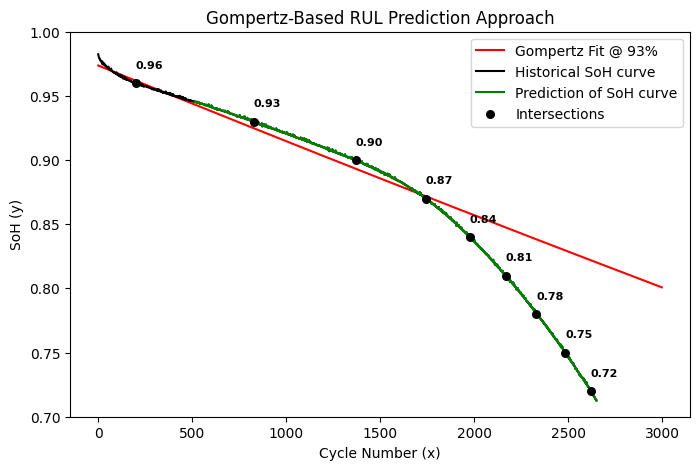

In [67]:
import matplotlib.cm as cm

df = pd.read_csv(base_path + choice + "-hust_gompertz_params.csv")
df['SoH'] = ((df['SoH']))
SoH_Thresholds = ['93%','90%','87%','84%','81%','78%','75%','72%']
cycle_nums = [511,941,1193,1380,1532,1663,1778,1886]

colors = cm.jet(np.linspace(0, 1, len(cycle_nums)))

def gompertz_func(x,k,a,b):
    return k*np.exp(-np.exp(a-(b*x)))
    
plt.figure(figsize=(8, 5))
for i, cycle_num in enumerate(cycle_nums):
    x = np.array([j/10000 for j in range(1,3000,1)]) 
    print(choice)
    print('SoH Threshold : ',SoH_Thresholds[i])
    temp_df = df[df['Cycle number']==cycle_num]
    k,a,b = temp_df['k'].item(),temp_df['a'].item(),temp_df['b'].item()
    print(k,a,b)
    #temp_df.head()
    # gompertz_func(x=df,k=k,a=a,b=b

    
    print("72% SoH RUL estimation: ",int(inverse_gompertz_func(y=0.72173913,k=k,a=a,b=b)*10000))


    # Compute y values
    y = gompertz_func(x,k,a,b)
    

    
    plt.plot(x*10000, y, label=f'Gompertz Fit @ {SoH_Thresholds[i]}', color='r')
    # plt.axhline(0, color='black', linewidth=0.5)
    # plt.axhline(1, color='black', linewidth=0.5)
    # plt.axvline(0, color='black', linewidth=0.5)
    plt.xlabel("Cycle Number (x)")
    plt.ylim(0.7, 1)
    plt.ylabel("SoH (y)")
    break
x_hits = []
y_hits = []
y = df['SoH'].to_numpy()
# Target values: 0.72 to 0.96 with step 0.03
target_values = np.arange(0.72, 0.96 + 0.001, 0.03)

# # Generate distinct colors for each threshold curve
# colors = cm.jet(np.linspace(0, 1, len(target_values)))

for idx_val, val in enumerate(target_values):
    # 1. Find intersection on the main blue line
    # We look for where the data crosses the 'val' threshold
    idx = np.where(np.diff(np.sign(y - val)))[0]
    
    if len(idx) > 0:
        inter = idx[0]
        # Linear interpolation for precise x-coordinate
        x_int = x[inter] + (x[inter+1] - x[inter]) * (val - y[inter]) / (y[inter+1] - y[inter])
        
        x_hits.append(x_int*10000)
        y_hits.append(val)
        
        # 2. Overlay Gompertz Curve (if df_params is provided)
        if df is not None:
            # Find the row in df_params with SoH closest to current 'val'
            # We assume df_params has a column 'SoH' (fractions like 0.93) or similar.
            # If df uses strings '93%', you might need to convert them first.
            
            # Finding closest match by absolute difference
            closest_row_idx = (df['SoH'] - val).abs().idxmin()
            row = df.loc[closest_row_idx]
            
            k, a, b = row['k'], row['a'], row['b']
            
            # Generate the Gompertz curve
            # NOTE: If k, a, b were fitted on INTEGER cycles, we must treat x as such
            # or assume the user has normalized k, a, b.
            # Here, we pass 'x' (0-1) directly. 
            #y_gomp = gompertz_func(x, k, a, b)
            
            # ax.plot(x, y_gomp, 
            #         color=colors[idx_val], 
            #         linestyle='--', 
            #         linewidth=1, 
            #         alpha=0.7,
            #         label=f"Fit @ {val:.2f}" if idx_val % 2 == 0 else "") # Label every other to reduce clutter

        # 3. Label the point
        plt.text(x_int*10000, val + 0.01, f"{val:.2f}", 
                rotation=0, va='bottom', ha='left', fontsize=8, fontweight='bold')

plt.plot(x[:len(df['SoH'])]*10000, df['SoH'], label='Historical SoH curve',color='black')
plt.plot(x[511:len(df['SoH'])]*10000, list(df['SoH'])[511:len(df['SoH'])], label='Prediction of SoH curve',color='green')
# Plot intersection dots
if x_hits:
    plt.scatter(x_hits, y_hits, color='k', s=30, zorder=5, label='Intersections')


plt.title(f"Gompertz-Based RUL Prediction Approach")
plt.legend()
plt.grid(not True)

# Show the plot
plt.show()

2-2
SoH Threshold :  93%
4.185697829552287 0.3772702078539097 -0.4194558584482366
72% SoH RUL estimation:  4452


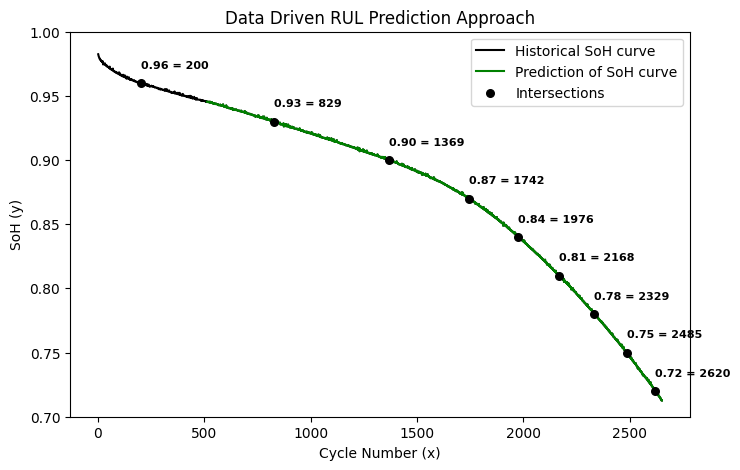

In [68]:
import matplotlib.cm as cm

df = pd.read_csv(base_path + choice + "-hust_gompertz_params.csv")

df['SoH'] = ((df['SoH']))
SoH_Thresholds = ['93%','90%','87%','84%','81%','78%','75%','72%']
cycle_nums = [511,941,1193,1380,1532,1663,1778,1886]#[63,431,637,758,849,925, 992, 1054,1110,1142] #[548,1031,1423,1756,1972,2153,2315,2473,2628,2688]
colors = cm.jet(np.linspace(0, 1, len(cycle_nums)))

def gompertz_func(x,k,a,b):
    return k*np.exp(-np.exp(a-(b*x)))
    
plt.figure(figsize=(8, 5))
for i, cycle_num in enumerate(cycle_nums):
    x = np.array([j/10000 for j in range(1,3000,1)]) 
    print(choice)
    print('SoH Threshold : ',SoH_Thresholds[i])
    temp_df = df[df['Cycle number']==cycle_num]
    k,a,b = temp_df['k'].item(),temp_df['a'].item(),temp_df['b'].item()
    print(k,a,b)
    #temp_df.head()
    # gompertz_func(x=df,k=k,a=a,b=b

    
    print("72% SoH RUL estimation: ",int(inverse_gompertz_func(y=0.72173913,k=k,a=a,b=b)*10000))


    # Compute y values
    y = gompertz_func(x,k,a,b)
    

    
    #plt.plot(x*10000, y, label=f'Gompertz Fit @ {SoH_Thresholds[i]}', color='r')
    # plt.axhline(0, color='black', linewidth=0.5)
    # plt.axhline(1, color='black', linewidth=0.5)
    # plt.axvline(0, color='black', linewidth=0.5)
    plt.xlabel("Cycle Number (x)")
    plt.ylim(0.7, 1)
    plt.ylabel("SoH (y)")
    break
x_hits = []
y_hits = []
y = df['SoH'].to_numpy()
# Target values: 0.72 to 0.96 with step 0.03
target_values = np.arange(0.72, 0.96 + 0.001, 0.03)

# # Generate distinct colors for each threshold curve
# colors = cm.jet(np.linspace(0, 1, len(target_values)))

for idx_val, val in enumerate(target_values):
    # 1. Find intersection on the main blue line
    # We look for where the data crosses the 'val' threshold
    idx = np.where(np.diff(np.sign(y - val)))[0]
    
    if len(idx) > 0:
        inter = idx[0]
        # Linear interpolation for precise x-coordinate
        x_int = x[inter] + (x[inter+1] - x[inter]) * (val - y[inter]) / (y[inter+1] - y[inter])
        
        x_hits.append(x_int*10000)
        y_hits.append(val)
        
        # 2. Overlay Gompertz Curve (if df_params is provided)
        if df is not None:
            # Find the row in df_params with SoH closest to current 'val'
            # We assume df_params has a column 'SoH' (fractions like 0.93) or similar.
            # If df uses strings '93%', you might need to convert them first.
            
            # Finding closest match by absolute difference
            closest_row_idx = (df['SoH'] - val).abs().idxmin()
            row = df.loc[closest_row_idx]
            
            k, a, b = row['k'], row['a'], row['b']
            
            # Generate the Gompertz curve
            # NOTE: If k, a, b were fitted on INTEGER cycles, we must treat x as such
            # or assume the user has normalized k, a, b.
            # Here, we pass 'x' (0-1) directly. 
            #y_gomp = gompertz_func(x, k, a, b)
            
            # ax.plot(x, y_gomp, 
            #         color=colors[idx_val], 
            #         linestyle='--', 
            #         linewidth=1, 
            #         alpha=0.7,
            #         label=f"Fit @ {val:.2f}" if idx_val % 2 == 0 else "") # Label every other to reduce clutter

        # 3. Label the point
        plt.text(x_int*10000, val + 0.01, f"{val:.2f} = {int(x_int*10000)}", 
                rotation=0, va='bottom', ha='left', fontsize=8, fontweight='bold')

plt.plot(x[:len(df['SoH'])]*10000, df['SoH'], label='Historical SoH curve',color='black')
plt.plot(x[511:len(df['SoH'])]*10000, list(df['SoH'])[511:len(df['SoH'])], label='Prediction of SoH curve',color='green')
#plt.plot(x[:941]*10000, df['SoH'][:941], label='Historical SoH curve',color='black')
#plt.plot(x[941:]*10000, df['SoH'][941:], label='Prediction of SoH curve',color='green')
# Plot intersection dots
if x_hits:
    plt.scatter(x_hits, y_hits, color='k', s=30, zorder=5, label='Intersections')


plt.title(f"Data Driven RUL Prediction Approach")
plt.legend()
plt.grid(not True)

# Show the plot
plt.show()